## Sumário

<a href=#fig>Figura</a>

<a href=#leitura>Leitura e Pré-processamento da base de dados</a>
<br><a href=#filtragem>Filtragem dos Dados</a>
<br><a href=#produtos>Seleção dos Produtos e Serviços</a>
<br><a href=#out_esp>Outliers</a>
<br><a href=#extreme>Extremos</a>
<br><a href=#prophet>Prophet</a>
<br><a href=#hw>Holt-Winters</a>
<br><a href=#sarima>SARIMA</a>
<br><a href=#dbscan>DBSCAN</a>
<br><a href=#lof>LOF</a>
<br><a href=#iforest>Isolation Forest</a>
<br><a href=#avaliacao>Avaliacao</a>

In [1]:
#rodar outro notebook

# %run ./called_notebook.ipynb
# foo()

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import altair as alt
import os
import math
import time
from IPython.display import HTML
from datetime import datetime
from sklearn.ensemble import IsolationForest
from sklearn.metrics import mean_squared_error
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from sklearn.preprocessing import MinMaxScaler

from matplotlib import pyplot
import statistics
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.api import ExponentialSmoothing

from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.cluster import DBSCAN
from sklearn import metrics

from sklearn.neighbors import LocalOutlierFactor

from sklearn.ensemble import IsolationForest

from sklearn.model_selection import GridSearchCV

# %matplotlib inline

In [3]:
# importando em célula diferente para evitar erros
from fbprophet import Prophet

Importing plotly failed. Interactive plots will not work.


# Leitura e Pré-processamento da base de dados <a name='leitura' />

In [4]:
data_original = pd.read_excel('awscguv5.xlsx')
data = data_original.copy()
data

inicio        fim                        produto  \
0     2020-08-01 2020-08-02                 AWS CloudTrail   
1     2020-08-01 2020-08-02                 AWS CloudTrail   
2     2020-08-01 2020-08-02                 AWS CloudTrail   
3     2020-08-01 2020-08-02                 AWS CloudTrail   
4     2020-08-01 2020-08-02                 AWS CloudTrail   
...          ...        ...                            ...   
91269 2020-11-30 2020-12-01  Amazon Simple Storage Service   
91270 2020-11-30 2020-12-01  Amazon Simple Storage Service   
91271 2020-11-30 2020-12-01  Amazon Simple Storage Service   
91272 2020-11-30 2020-12-01  Amazon Simple Storage Service   
91273 2020-11-30 2020-12-01  Amazon Simple Storage Service   

                       servico           qnt unidade      conta  
0      APN1-FreeEventsRecorded  4.430000e+12  Events  principal  
1          APN1-InsightsEvents  1.300000e+11  Events  principal  
2      APN2-FreeEventsRecorded  4.440000e+12  Events  principal  
3          APN2-InsightsEvents  1.300000e+11  Events  principal  
4      APS1-FreeEventsRecorded  4.420000e+12  Events  principal  
...                        ...           ...     ...        ...  
91269  USE1-EUW3-AWS-Out-Bytes  5.178000e-07      GB  seguranca  
91270  USE1-SAE1-AWS-Out-Bytes  1.553400e-06      GB  seguranca  
91271  USE1-USE2-AWS-Out-Bytes  5.178000e-07      GB  seguranca  
91272  USE1-USW1-AWS-Out-Bytes  5.178000e-07      GB  seguranca  
91273  USE1-USW2-AWS-Out-Bytes  5.178000e-07      GB  seguranca  

[91274 rows x 7 columns]

In [5]:
#Verificando o tipo de cada coluna
data.dtypes

inicio     datetime64[ns]
fim        datetime64[ns]
produto            object
servico            object
qnt               float64
unidade            object
conta              object
dtype: object

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91274 entries, 0 to 91273
Data columns (total 7 columns):
inicio     91274 non-null datetime64[ns]
fim        91274 non-null datetime64[ns]
produto    91274 non-null object
servico    91274 non-null object
qnt        91274 non-null float64
unidade    91271 non-null object
conta      91274 non-null object
dtypes: datetime64[ns](2), float64(1), object(4)
memory usage: 4.9+ MB


Não há valores nulos na base de dados. São 8 colunas, sendo 'inicio' e 'fim' do tipo datetime, 'qnt' do tipo float e o restante tipo object.

In [7]:
#classificando os dados de acordo com a coluna de datas "inicio"
data =  data.sort_values(by="inicio")

## Análise Descritiva e Seleção/Filtragem dos dados <a name='filtragem' />

Text(2, 17621.75, '19851')

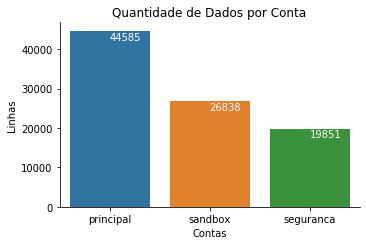

In [8]:
conta_qnt = data['conta'].value_counts().tolist()

fig1 = sns.catplot(x='conta', kind='count', data=data).set(title='Quantidade de Dados por Conta', 
                                                           xlabel='Contas',
                                                           ylabel='Linhas')
# sns.set(font_scale=1.4) #aumentar fonte dos textos
fig1.fig.set_size_inches(5,3)
# fig1.fig.subplots_adjust(top=0.81,right=0.86)
# fig1.set_xlabel("X Label",size=30)
fig1.ax.text(0,conta_qnt[0]-conta_qnt[0]*0.05,conta_qnt[0],fontsize=10, color='white')
fig1.ax.text(1,conta_qnt[1]-conta_qnt[0]*0.05,conta_qnt[1],fontsize=10, color='white')
fig1.ax.text(2,conta_qnt[2]-conta_qnt[0]*0.05,conta_qnt[2],fontsize=10, color='white')

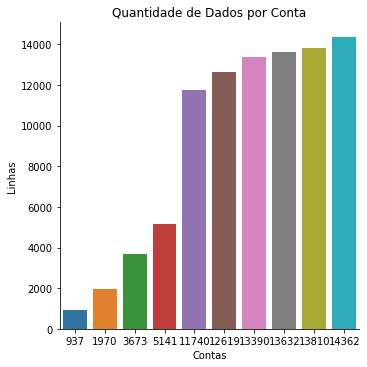

In [9]:

data_graph = data.copy()
data_graph['inicio'] = pd.to_datetime(data_graph['inicio'])
m = data_graph['inicio'].dt.month

data_graph['Count_m'] = data_graph.groupby([pd.Grouper(key='inicio', freq='M')])['inicio'].transform('size').astype(int)

sns.catplot(x='Count_m', kind='count', data=data_graph).set(title='Quantidade de Dados por Conta', 
                                                           xlabel='Contas',
                                                           ylabel='Linhas')


<BarContainer object of 10 artists>

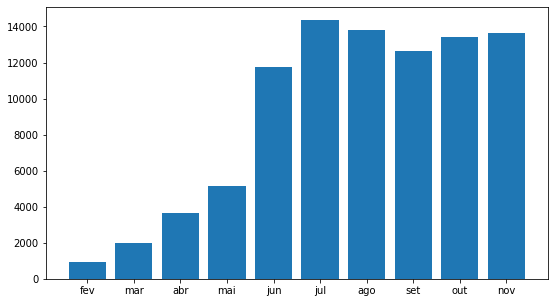

In [10]:
meses = ['fev', 'mar', 'abr', 'mai', 'jun', 'jul', 'ago', 'set', 'out', 'nov' ]

plt.figure(figsize=(9, 5))
plt.bar(meses, data_graph['Count_m'].unique())

In [11]:
# Iremos utilizar na análise somente dados da conta principal
data = data[data['conta']=='principal']

In [12]:
print('Quantidade de PRODUTOS na base de dados da conta principal:',len(data['produto'].value_counts().tolist()))
data['produto'].value_counts()

Quantidade de PRODUTOS na base de dados da conta principal: 27


Amazon Simple Storage Service             9146
AWS CloudTrail                            5685
EC2 - Other                               3917
Amazon Simple Notification Service        3080
AWS Config                                2995
Amazon Virtual Private Cloud              2754
Amazon Elastic Load Balancing             2709
AWS Key Management Service                2630
Amazon Simple Queue Service               2609
Amazon DynamoDB                           2377
AmazonCloudWatch                          1880
Amazon Elastic Compute Cloud - Compute    1850
Amazon CloudFront                         1024
AWS WAF                                    760
Tax                                        389
AWS Secrets Manager                        262
AWS Lambda                                 156
AWS Cost Explorer                          106
AWS Security Hub                           100
AWS Budgets                                 98
AWS Elemental MediaStore                    40
Amazon Simple

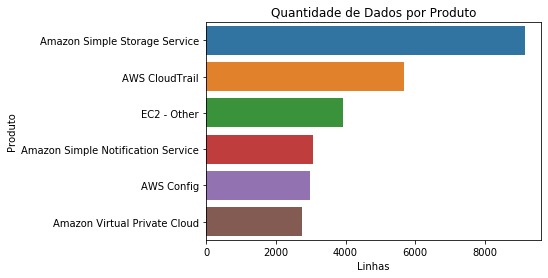

In [13]:
fig1 = sns.countplot(y='produto', data=data, order=pd.value_counts(data['produto']).iloc[:6].index).set(title='Quantidade de Dados por Produto', 
                                                           xlabel='Linhas',
                                                           ylabel='Produto')
# sns.set(font_scale=1.4) #aumentar fonte dos textos
# fig1.fig.set_size_inches(10,6)
# # fig1.fig.subplots_adjust(top=0.81,right=0.86)
# # fig1.set_xlabel("X Label",size=30)
# fig1.ax.text(0,conta_qnt[0]-conta_qnt[0]*0.05,conta_qnt[0],fontsize=20, color='white')
# fig1.ax.text(1,conta_qnt[1]-conta_qnt[0]*0.05,conta_qnt[1],fontsize=20, color='white')
# fig1.ax.text(2,conta_qnt[2]-conta_qnt[0]*0.05,conta_qnt[2],fontsize=20, color='white')

In [14]:
data

inicio        fim                       produto  \
19613 2020-02-01 2020-02-02  Amazon Virtual Private Cloud   
23786 2020-02-01 2020-02-02                           Tax   
24043 2020-02-01 2020-02-02                           Tax   
21846 2020-02-01 2020-02-02                   EC2 - Other   
21847 2020-02-01 2020-02-02                           Tax   
...          ...        ...                           ...   
84419 2020-11-30 2020-12-01              AmazonCloudWatch   
84420 2020-11-30 2020-12-01              AmazonCloudWatch   
84421 2020-11-30 2020-12-01              AmazonCloudWatch   
84422 2020-11-30 2020-12-01              AmazonCloudWatch   
84423 2020-11-30 2020-12-01              AmazonCloudWatch   

                            servico           qnt   unidade      conta  
19613    SAE1-DataTransfer-In-Bytes  4.754690e-05        GB  principal  
23786  SAE1-VPN-Usage-Hours:ipsec.1  0.000000e+00       Hrs  principal  
24043               USE1-APIRequest  0.000000e+00  Requests  principal  
21846         SAE1-NatGateway-Hours  9.600000e+01       Hrs  principal  
21847         SAE1-NatGateway-Hours  0.000000e+00       Hrs  principal  
...                             ...           ...       ...        ...  
84419    SAE1-CW:MetricMonitorUsage  2.833333e-01   Metrics  principal  
84420              SAE1-CW:Requests  1.963980e+15  Requests  principal  
84421     SAE1-DataProcessing-Bytes  5.412481e-01        GB  principal  
84422     SAE1-TimedStorage-ByteHrs  6.910993e+10  GB-Month  principal  
84423          SAE1-VendedLog-Bytes  3.447194e-01        GB  principal  

[44585 rows x 7 columns]

# Seleção da Série Temporal da Base de dados <a name='produtos' />

![image.png](attachment:image.png)

    





In [15]:
#criando dicionário com todos os produtos e serviços

nuvem = {
    'Amazon Simple Storage Service':['Requests-Tier1','Requests-Tier2','SAE1-USE1-AWS-Out-Bytes'],
    'EC2 - Other':['SAE1-DataTransfer-Regional-Bytes','SAE1-EU-AWS-In-Bytes','SAE1-NatGateway-Bytes'],
    'Amazon Virtual Private Cloud':['SAE1-DataTransfer-In-Bytes','SAE1-USW2-AWS-In-Bytes','SAE1-USE1-AWS-In-Bytes']
}

## Criando função para a transformação do DataFrame em Série Temporal Univariada

In [16]:
def serie_temporal (data, produto, sevico):
    #Filtrando a base de dados para obtermos uma base univariada e com dados temporais no eixo X
    data = data[data['produto']==produto]
    data = data[data['servico']==servico]
    data= data.drop(columns=['fim','produto','servico','unidade','conta'])
    linhas_antes_fill = len(data)
    print('Quantidade de linhas da base de dados:',linhas_antes_fill)
    
    # data = data.reset_index(drop=True)
    data = data.reset_index(drop=True)

    # colocando valores 0 para os dias em que não houver dados
    data = data.set_index('inicio').asfreq('d', fill_value=0)

    linhas_depois_fill = len(data)

    print('Quantidade de linhas da base de dados após inserção de valores 0 em dias faltantes:',linhas_depois_fill)
    print('Linhas adicionadas:',linhas_depois_fill-linhas_antes_fill)

    data = data.reset_index()
    scaler = MinMaxScaler()
    scaler.fit(np.array(data['qnt']).reshape(-1,1))
    data['qnt'] = scaler.transform(np.array(data['qnt']).reshape(-1,1))
    
    #gravando arquivo csv
    filename = "Series\serie_"+produto+"_"+servico+".csv"
    data.to_csv(filename,index = True, header=True)
    
    print('Série gravada em: ',filename)
    print('======= DONE =======')
    print()
    
    return data

In [17]:
for key in nuvem:
    for value in nuvem[key]:
        produto = key
        servico = value
        print('=== ',produto,' / ', servico,' ====')
        serie_temporal (data, produto, servico)
        

===  Amazon Simple Storage Service  /  Requests-Tier1  ====
Quantidade de linhas da base de dados: 265
Quantidade de linhas da base de dados após inserção de valores 0 em dias faltantes: 300
Linhas adicionadas: 35
Série gravada em:  Series\serie_Amazon Simple Storage Service_Requests-Tier1.csv
======= DONE =======

===  Amazon Simple Storage Service  /  Requests-Tier2  ====
Quantidade de linhas da base de dados: 219
Quantidade de linhas da base de dados após inserção de valores 0 em dias faltantes: 300
Linhas adicionadas: 81
Série gravada em:  Series\serie_Amazon Simple Storage Service_Requests-Tier2.csv
======= DONE =======

===  Amazon Simple Storage Service  /  SAE1-USE1-AWS-Out-Bytes  ====
Quantidade de linhas da base de dados: 213
Quantidade de linhas da base de dados após inserção de valores 0 em dias faltantes: 300
Linhas adicionadas: 87
Série gravada em:  Series\serie_Amazon Simple Storage Service_SAE1-USE1-AWS-Out-Bytes.csv
======= DONE =======

===  EC2 - Other  /  SAE1-DataT

## Outliers dos Especialistas <a name='out_esp' />

In [18]:
# criando as tabelas com os outliers apontados de forma manual pelo especialista

# foi adicionado a cada série de outliers a data 2020-01-01 para garantir que exista uma linha sem outliers no dataframe
# necessário para calcular o AUC

# vpc_dt= ['2020-01-01','2020-06-05','2020-07-06','2020-08-17','2020-08-18'] 
# vpc_usw2= ['2020-01-01','2020-02-10', '2020-02-18', '2020-03-31','2020-04-06', '2020-04-25', '2020-04-26', '2020-04-29', '2020-05-16','2020-05-17', '2020-08-25','2020-09-10','2020-09-17','2020-09-27','2020-10-08','2020-10-15']
# vpc_use1= ['2020-01-01','2020-02-17', '2020-03-05', '2020-03-06','2020-04-03', '2020-08-06']
# ec2_dt= ['2020-01-01','2020-06-17','2020-07-15','2020-08-11', '2020-08-20', '2020-08-21','2020-08-28', '2020-09-04']
# ec2_eu= ['2020-01-01','2020-06-10','2020-06-17','2020-06-24', '2020-06-27', '2020-07-01','2020-07-03', '2020-07-15','2020-07-18','2020-07-24','2020-07-25','2020-08-25','2020-09-04']
# ec2_ng= ['2020-01-01','2020-06-04','2020-06-10','2020-06-17','2020-06-19','2020-06-24', '2020-06-27', '2020-07-14','2020-07-15','2020-07-18','2020-07-25','2020-07-26','2020-09-04']
# st_t1= ['2020-01-01','2020-06-17', '2020-07-09', '2020-08-30','2020-09-01', '2020-09-09', '2020-10-13', '2020-10-20']
# st_t2= ['2020-01-01','2020-08-18','2020-08-19','2020-08-20', '2020-09-04', '2020-09-30']
# st_sae= ['2020-01-01','2020-02-06','2020-02-07', '2020-05-07', '2020-07-01', '2020-07-09', '2020-07-13', '2020-07-14','2020-07-21', '2020-07-28','2020-09-16','2020-09-17','2020-10-02']

#corrigindo os outliers para melhorar evaluate
# vpc_dt= ['2020-01-01','2020-06-05','2020-07-06','2020-08-17','2020-08-18'] 
# vpc_usw2= ['2020-01-01','2020-02-10', '2020-02-18', '2020-03-31','2020-04-06', '2020-04-25', '2020-04-26', '2020-04-29', '2020-05-16','2020-05-17', '2020-08-25','2020-09-10','2020-09-17','2020-09-27','2020-10-08','2020-10-15']
# vpc_use1= ['2020-01-01','2020-02-17', '2020-03-05', '2020-03-06','2020-04-03', '2020-08-06']
# ec2_dt= ['2020-01-01','2020-06-17','2020-07-15','2020-08-11', '2020-08-20', '2020-08-21','2020-08-28', '2020-09-04']
# ec2_eu= ['2020-01-01','2020-06-10','2020-07-03', '2020-07-14','2020-07-15','2020-07-18','2020-07-19','2020-07-24','2020-07-25','2020-07-26','2020-09-04']
# ec2_ng= ['2020-01-01','2020-06-04','2020-06-05','2020-06-10','2020-06-11','2020-06-15','2020-06-16','2020-06-17','2020-06-18','2020-06-24', '2020-06-27', '2020-07-03','2020-07-14','2020-07-15','2020-07-16','2020-07-18','2020-07-25','2020-07-26','2020-08-25','2020-09-04']
# st_t1= ['2020-01-01','2020-06-17', '2020-07-09', '2020-08-30','2020-09-01', '2020-09-09', '2020-10-13', '2020-10-20']
# st_t2= ['2020-01-01','2020-08-18','2020-08-19','2020-08-20', '2020-09-04', '2020-09-30']
# st_sae= ['2020-01-01','2020-02-06','2020-02-07', '2020-05-07', '2020-07-01', '2020-07-09', '2020-07-13', '2020-07-14','2020-07-21', '2020-07-28','2020-09-16','2020-09-17','2020-10-02']

#retirando os dias 1 de janeiro pois com a série toda não é necessário
# vpc_dt= ['2020-06-05','2020-07-06','2020-08-17','2020-08-18'] 
# vpc_usw2= ['2020-02-10', '2020-02-18', '2020-03-31','2020-04-06', '2020-04-25', '2020-04-26', '2020-04-29', '2020-05-16','2020-05-17', '2020-08-25','2020-09-10','2020-09-17','2020-09-27','2020-10-08','2020-10-15']
# vpc_use1= ['2020-02-17', '2020-03-05', '2020-03-06','2020-04-03', '2020-08-06']
# ec2_dt= ['2020-06-17','2020-07-15','2020-08-11', '2020-08-20', '2020-08-21','2020-08-28', '2020-09-04']
# ec2_eu= ['2020-06-10','2020-07-03', '2020-07-14','2020-07-15','2020-07-18','2020-07-19','2020-07-24','2020-07-25','2020-07-26','2020-09-04']
# ec2_ng= ['2020-06-04','2020-06-05','2020-06-10','2020-06-11','2020-06-15','2020-06-16','2020-06-17','2020-06-18','2020-06-24', '2020-06-27', '2020-07-03','2020-07-14','2020-07-15','2020-07-16','2020-07-18','2020-07-25','2020-07-26','2020-08-25','2020-09-04']
# st_t1= ['2020-06-17', '2020-07-09', '2020-08-30','2020-09-01', '2020-09-09', '2020-10-13', '2020-10-20']
# st_t2= ['2020-08-18','2020-08-19','2020-08-20', '2020-09-04', '2020-09-30']
# st_sae= ['2020-02-06','2020-02-07', '2020-05-07', '2020-07-01', '2020-07-09', '2020-07-13', '2020-07-14','2020-07-21', '2020-07-28','2020-09-16','2020-09-17','2020-10-02']


# #atualizando com outliers nov
# vpc_dt= ['2020-06-05','2020-07-06','2020-08-17','2020-08-18'] 
# vpc_usw2= ['2020-02-10', '2020-02-18', '2020-03-31','2020-04-06', '2020-04-25', '2020-04-26', '2020-04-29', '2020-05-16','2020-05-17', '2020-08-25','2020-09-10','2020-09-17','2020-09-27','2020-10-08','2020-10-15', '2020-11-12']
# vpc_use1= ['2020-02-17', '2020-03-05', '2020-03-06','2020-04-03', '2020-06-08','2020-11-12','2020-11-13','2020-11-24','2020-11-26' ]
# ec2_dt= ['2020-06-17','2020-07-15','2020-08-11', '2020-08-20', '2020-08-21','2020-08-28', '2020-09-04']
# ec2_eu= ['2020-06-10','2020-07-03', '2020-07-14','2020-07-15','2020-07-18','2020-07-19','2020-07-24','2020-07-25','2020-07-26','2020-09-04']
# ec2_ng= ['2020-06-04','2020-06-05','2020-06-10','2020-06-11','2020-06-15','2020-06-16','2020-06-17','2020-06-18','2020-06-24', '2020-06-27', '2020-07-03','2020-07-14','2020-07-15','2020-07-16','2020-07-18','2020-07-25','2020-07-26','2020-08-25','2020-09-04']
# st_t1= ['2020-06-17', '2020-07-09', '2020-08-30','2020-09-01', '2020-09-09', '2020-10-10','2020-10-13', '2020-10-20','2020-11-09','2020-11-10','2020-11-11','2020-11-15','2020-11-18','2020-11-24','2020-11-29']
# st_t2= ['2020-08-18','2020-08-19','2020-08-20', '2020-09-04', '2020-09-30','2020-11-26','2020-11-27' ]
# st_sae= ['2020-02-06','2020-02-07', '2020-05-07', '2020-07-01', '2020-07-09', '2020-07-13', '2020-07-14','2020-07-21', '2020-07-28','2020-09-16','2020-09-17','2020-10-02']


#atualizando endo todas séries
st_t1= ['2020-06-17', '2020-07-09', '2020-08-16','2020-08-30','2020-09-01', '2020-09-07','2020-09-09', '2020-10-13', '2020-10-20','2020-11-09','2020-11-12','2020-11-15','2020-11-18','2020-11-24','2020-11-29']
st_t2= ['2020-08-18','2020-08-19','2020-08-20', '2020-09-04', '2020-09-30','2020-11-26','2020-11-27' ]
st_sae= ['2020-02-06','2020-02-07', '2020-05-07', '2020-07-01', '2020-07-09', '2020-07-13', '2020-07-14','2020-07-21', '2020-07-28','2020-09-16','2020-09-17','2020-10-02']
ec2_dt= ['2020-06-05','2020-06-10','2020-06-17','2020-07-03','2020-07-15','2020-08-11', '2020-08-20', '2020-08-21','2020-08-27','2020-08-28', '2020-09-04']
ec2_eu= ['2020-06-10','2020-06-13','2020-06-14','2020-06-17','2020-06-24','2020-07-01','2020-07-03', '2020-07-07','2020-07-14','2020-07-15','2020-07-16','2020-07-18','2020-07-19','2020-07-24','2020-07-25','2020-07-26','2020-09-03','2020-09-04']
ec2_ng= ['2020-06-04','2020-06-05','2020-06-10','2020-06-11','2020-06-13','2020-06-15','2020-06-16','2020-06-17','2020-06-18','2020-06-19','2020-06-24', '2020-06-27', '2020-07-03','2020-07-14','2020-07-15','2020-07-16','2020-07-18','2020-07-19','2020-07-25','2020-07-26','2020-08-25','2020-09-04']
vpc_dt= ['2020-06-05','2020-07-06','2020-07-15','2020-08-17','2020-08-18'] 
vpc_usw2= ['2020-02-10', '2020-02-18', '2020-03-31','2020-04-06', '2020-04-25', '2020-04-26', '2020-04-29', '2020-05-01','2020-05-16','2020-05-17', '2020-08-25','2020-09-10','2020-09-17','2020-09-27','2020-10-08','2020-10-15', '2020-11-12']
vpc_use1= ['2020-02-17', '2020-03-05', '2020-03-06','2020-04-03', '2020-06-08','2020-11-12','2020-11-13','2020-11-24','2020-11-26' ]

outliers_espec = [st_t1,st_t2,st_sae,ec2_dt,ec2_eu,ec2_ng,vpc_dt, vpc_usw2,vpc_use1]

## Séries Escolhidas e seus Outliers

In [19]:
def series_outliers (produto, servico, outliers):
    filename = "Series\serie_"+produto+"_"+servico+".csv"
#     print(filename)
    data = pd.read_csv(filename, index_col='inicio', parse_dates=True)
    data.index.freq = 'D'
    data = data.drop(columns='Unnamed: 0')
    
    tamanho_serie = data.shape[0]
    
    
    
    plt.rcParams['figure.figsize'] = [6,4]
    fig, ax = plt.subplots()
    ax.plot(data.index, data['qnt'], label='Dados')
       
    # marcando as anomalias em vermelho
#     ax.plot(outliers.index, data['qnt'][outliers.index], 'rX', markersize=8,  label='Outliers Especialista')
    ax.scatter(outliers.index, data['qnt'][outliers.index], marker='x',color='r',linewidths=3,  label='Pontos de Interesse')
    
    ax.set(xlabel='Data', ylabel='Consumo Normalizado',
#            title='Pontos de Interesse do Especialista\nProduto: '+produto+'\nServiço: '+servico
          )
    
    plt.suptitle('Pontos de Interesse do Especialista',y=1.05,fontsize=13)
    plt.title('Produto: '+produto+'\nServiço: '+servico,fontsize=10, loc='center')
    
    
    #rotacionando os textos do eixo x
    fig.autofmt_xdate()
           
    
    #removendo as datas do gráfico
#     plt.tick_params(
#         axis='x',          # changes apply to the x-axis
#         which='both',      # both major and minor ticks are affected
#         bottom=False,      # ticks along the bottom edge are off
#         top=False,         # ticks along the top edge are off
#         labelbottom=False) # labels along the bottom edge are off
# #     #ax.grid()
    ax.legend()

    #Salvando a figura
    filename = "Figuras\\"+produto+"_"+servico+"_series_outliers.png"
    plt.savefig(filename)

    plt.show()
    
    return tamanho_serie



In [20]:
def array_to_time_serie (outliers_espec):

    # outliers_espec = ['2020-02-06', '2020-05-07', '2020-07-01', '2020-07-09', '2020-07-13', '2020-07-21', '2020-07-28']
    # outliers_espec = np.array(outliers_espec, dtype=np.datetime64)
    df_outliers_espec = pd.DataFrame()
    df_outliers_espec['data'] = outliers_espec
    df_outliers_espec['data'] = pd.to_datetime(df_outliers_espec['data'])
    df_outliers_espec['especialista'] = 1
    df_outliers_espec= df_outliers_espec.set_index('data')

    return df_outliers_espec


In [21]:
qnt_out_espec = []

i=0

for out in outliers_espec:
    qnt_out_espec.append(len(out)) 
        
print(qnt_out_espec)

[15, 7, 12, 11, 18, 22, 5, 17, 9]


Amazon Simple Storage Service Requests-Tier1


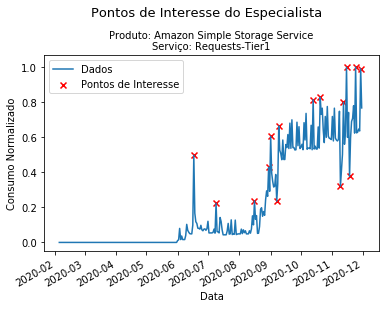

Amazon Simple Storage Service Requests-Tier2


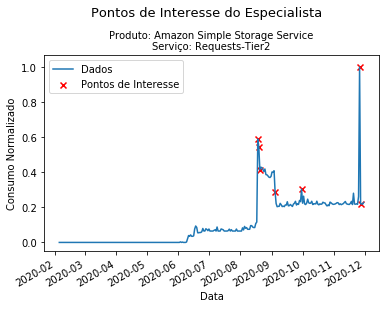

Amazon Simple Storage Service SAE1-USE1-AWS-Out-Bytes


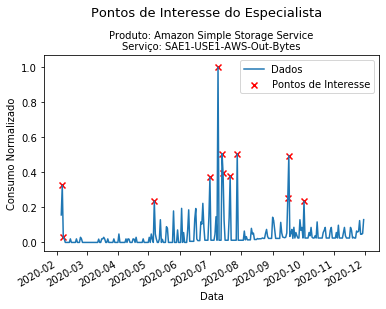

EC2 - Other SAE1-DataTransfer-Regional-Bytes


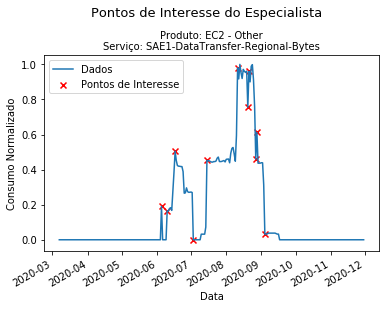

EC2 - Other SAE1-EU-AWS-In-Bytes


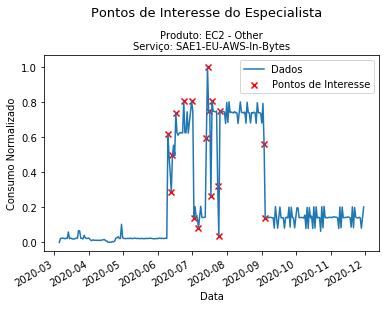

EC2 - Other SAE1-NatGateway-Bytes


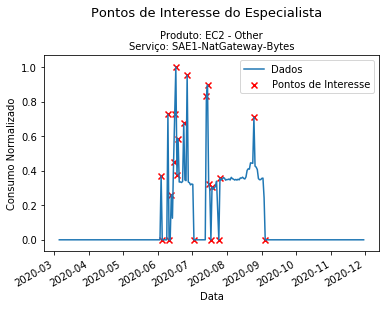

Amazon Virtual Private Cloud SAE1-DataTransfer-In-Bytes


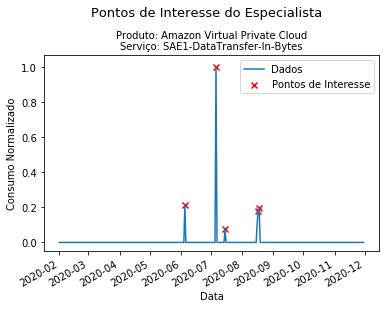

Amazon Virtual Private Cloud SAE1-USW2-AWS-In-Bytes


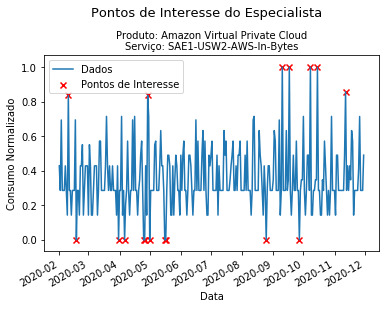

Amazon Virtual Private Cloud SAE1-USE1-AWS-In-Bytes


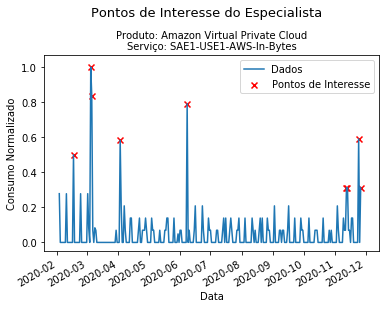

In [22]:
i = 0

tamanho_series = []

for key in nuvem:
    for value in nuvem[key]:
        
        print(key,value)
                
        produto = key
        servico = value

        outliers = array_to_time_serie(outliers_espec[i])    
        tamanho_series.append (series_outliers (produto, servico, outliers))
        i=i+1

In [23]:
print(tamanho_series)
inliers=np.subtract(tamanho_series,qnt_out_espec)
print(inliers)
print(qnt_out_espec)

[300, 300, 300, 269, 270, 270, 304, 304, 298]
[285 293 288 258 252 248 299 287 289]
[15, 7, 12, 11, 18, 22, 5, 17, 9]


In [24]:
aux = 0
percent = []

for i in inliers:
    percent.append(round(((qnt_out_espec[aux]*100)/i),2))
    i = i+1

print(percent)
print(statistics.mean(percent))


[5.26, 5.12, 5.21, 5.81, 5.95, 6.05, 5.02, 5.23, 5.19]
5.426666666666667


## Características das Séries Temporais

In [25]:
def distribuicao (produto, servico):
    filename = "Series\serie_"+produto+"_"+servico+".csv"
#     print(filename)
    data = pd.read_csv(filename, index_col='inicio', parse_dates=True)
    data.index.freq = 'D'
    data = data.drop(columns='Unnamed: 0')
    
    
#     print(data)
#     print(data.index)
#     print(data.dtypes)
    

    fig, ax = plt.subplots()
#     sns.distplot(data['qnt'], bins=5)
    sns.distplot(data['qnt'])
    ax.set(title=produto+': '+servico)
    
    
    plt.rcParams['figure.figsize'] = [12,8]
    result = seasonal_decompose(data, model='additive')
    result.plot()
    pyplot.show()
    
    # zoom na sazonalidade
#     fig2, ax2 = plt.subplots()
#     plt.rcParams['figure.figsize'] = [5,3]
#     result.seasonal['2020-03-01':'2020-04-01'].plot()


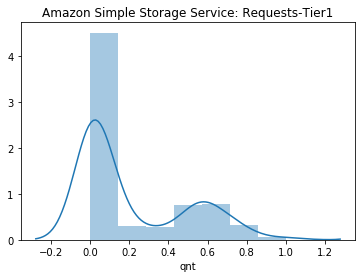

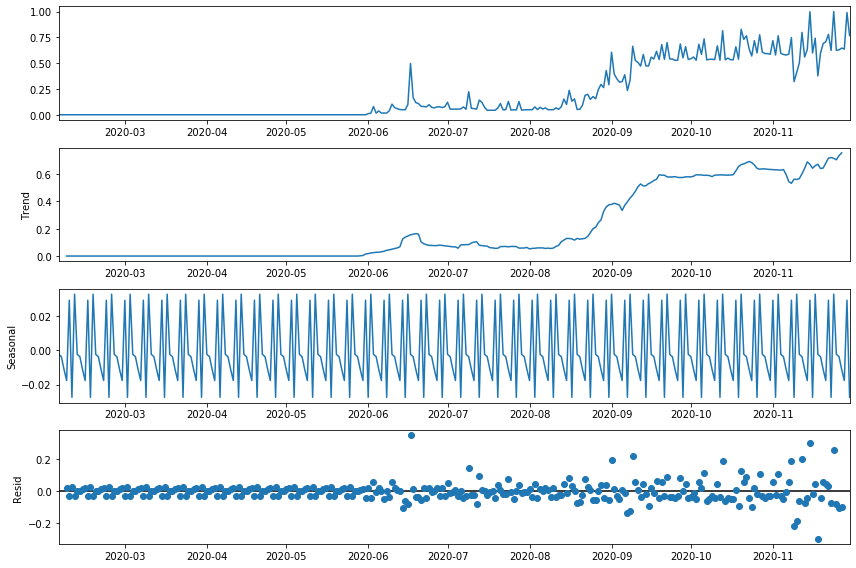

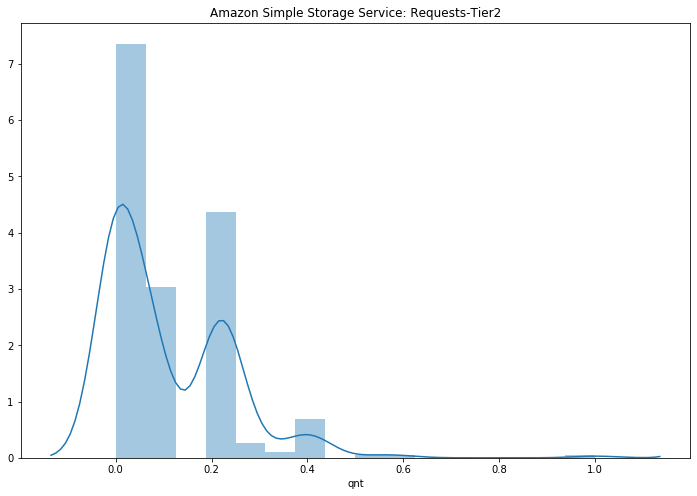

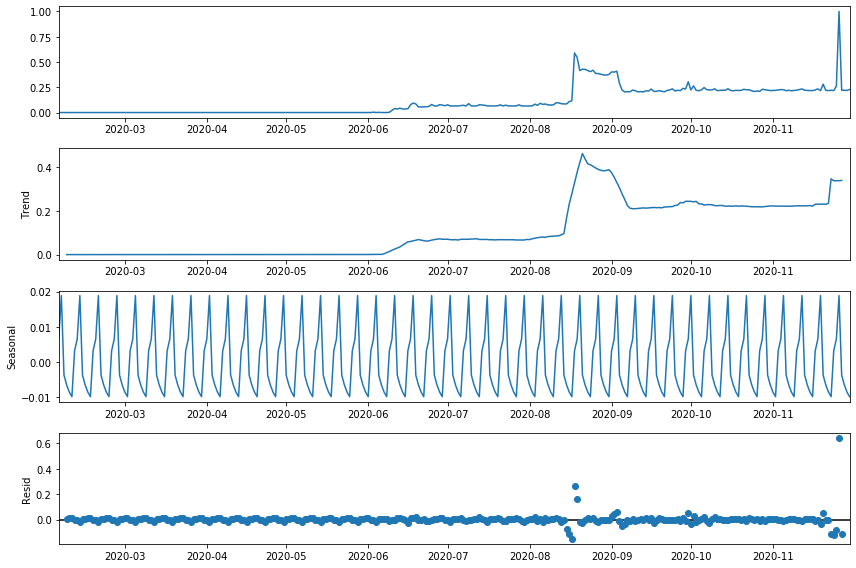

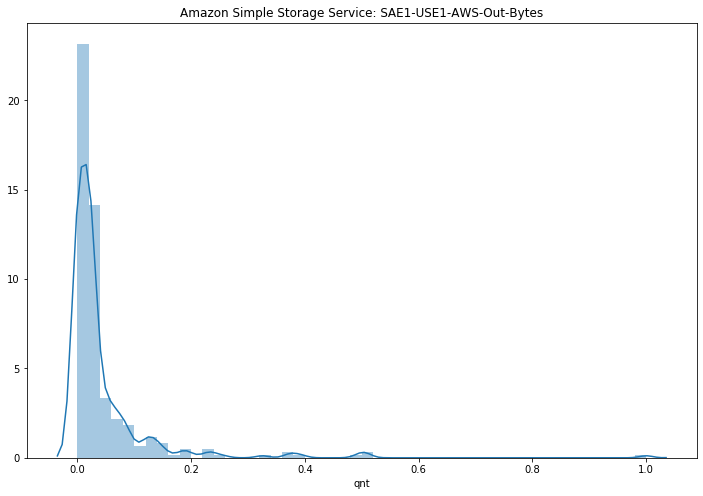

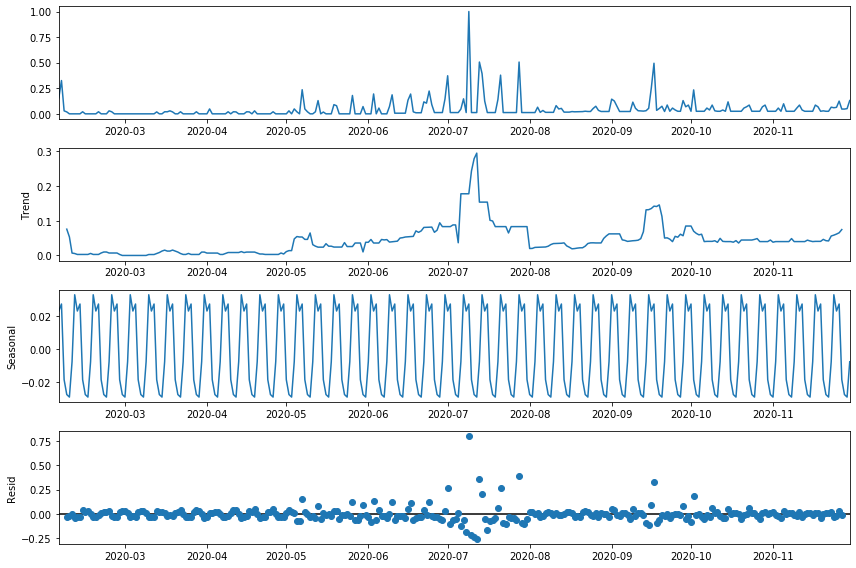

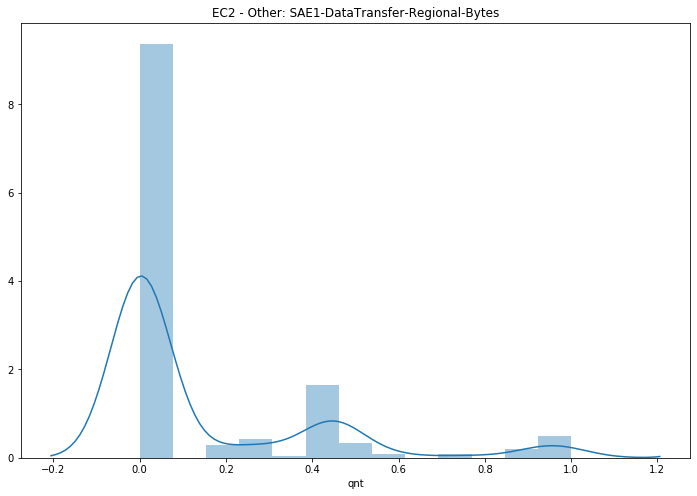

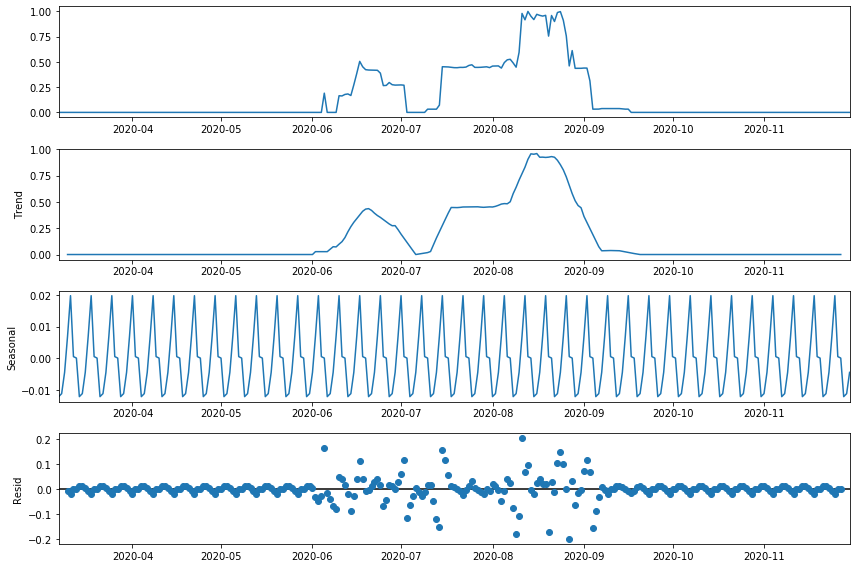

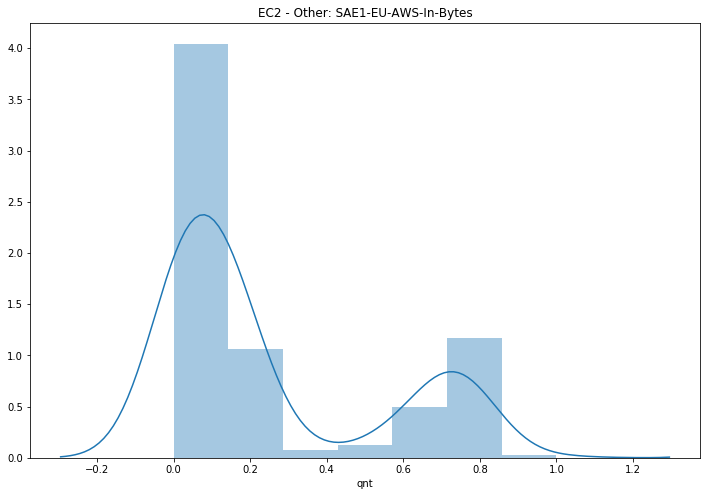

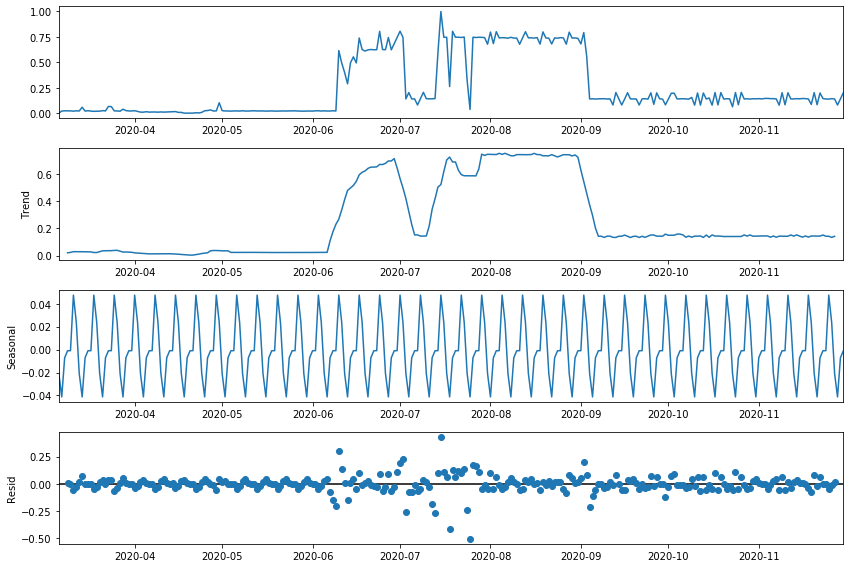

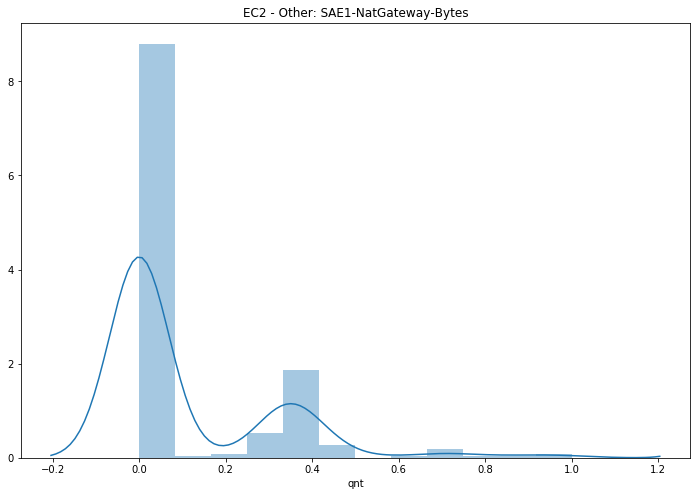

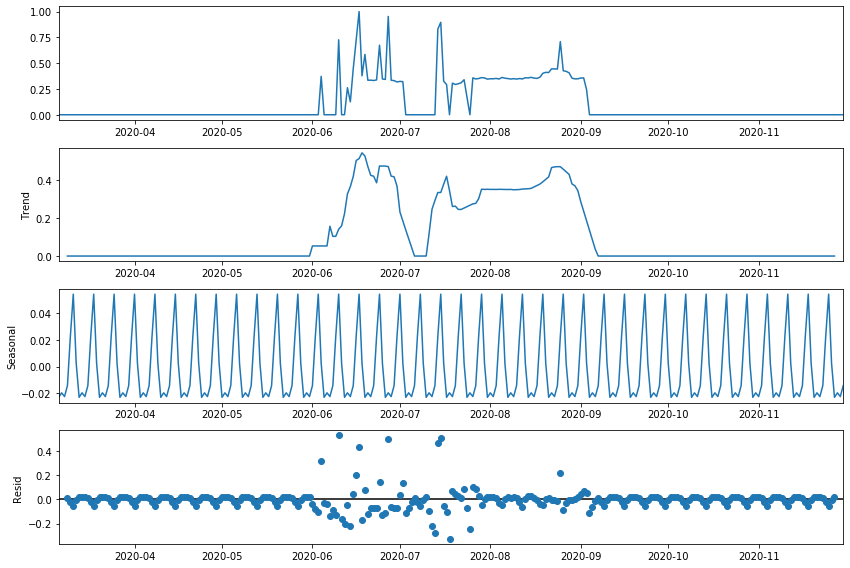

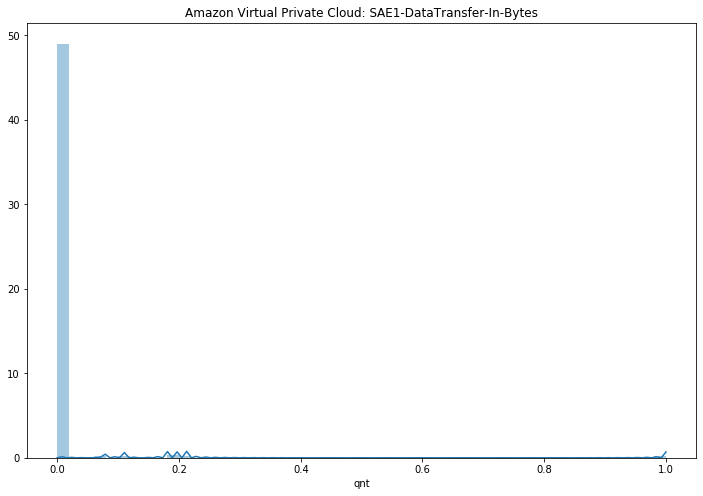

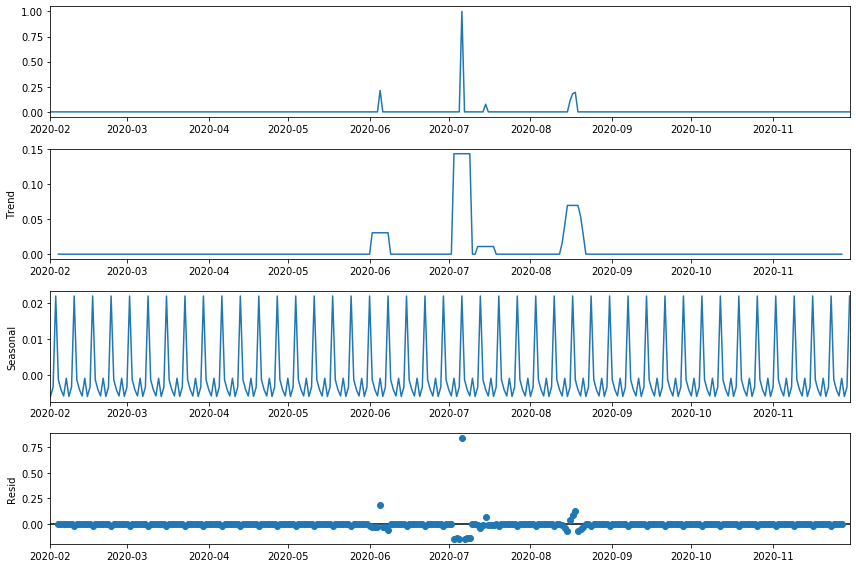

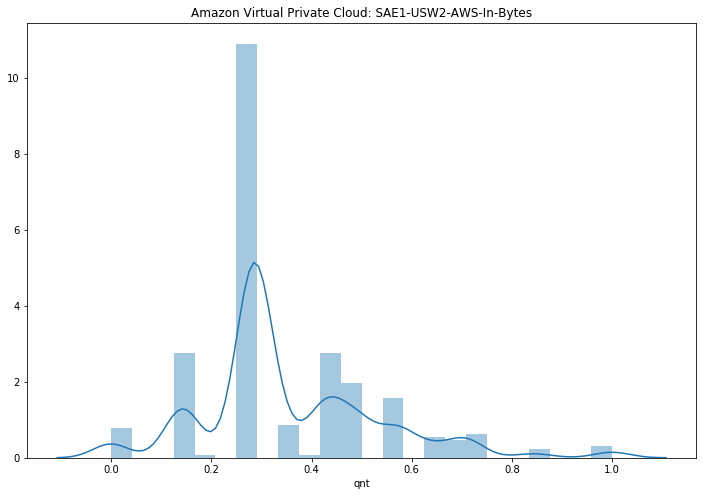

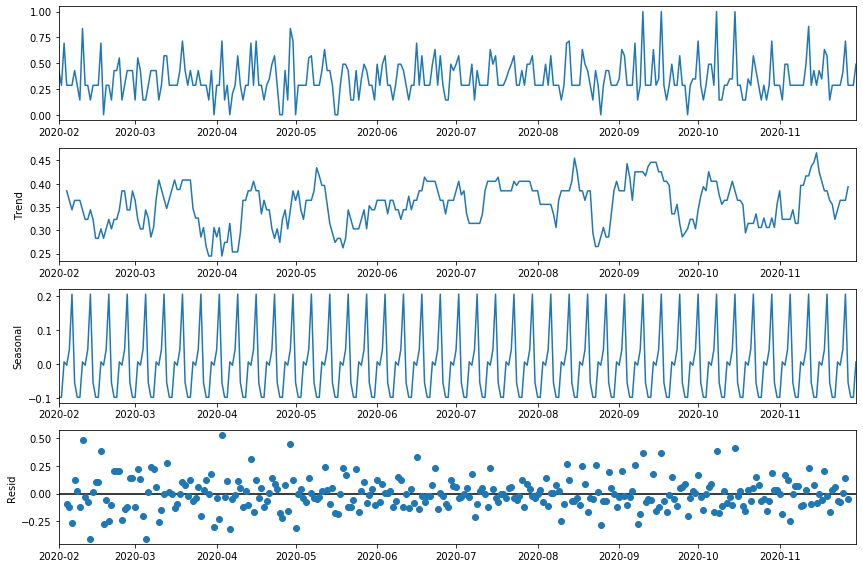

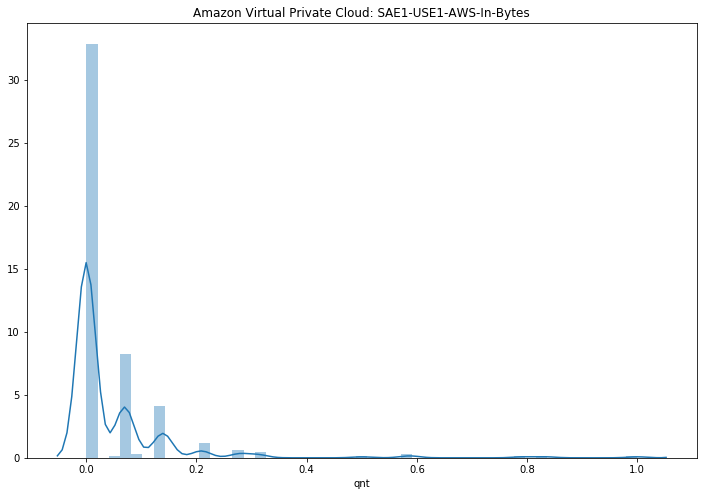

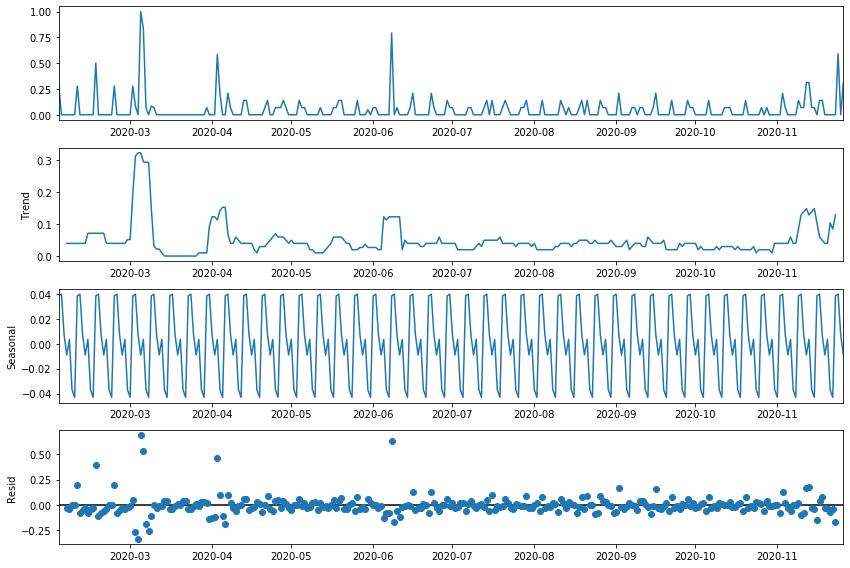

In [26]:
for key in nuvem:
    for value in nuvem[key]:
        produto = key
        servico = value
#         print('=== ',produto,' / ', servico,' ====')
        distribuicao (produto, servico)

## VALORES EXTREMOS <a name='extreme' />

In [27]:
def ddo_extremos (produto, servico):
    filename = "Series\serie_"+produto+"_"+servico+".csv"
#     print(filename)
    data = pd.read_csv(filename)
    

    fig1, ax1 = plt.subplots()
#     ax1.plot(data['inicio'], data['qnt'], label='Dados')
#     sns.distplot(data['qnt'])
    ax1.set(title=produto+': '+servico)
    sns.boxplot(y = data['qnt'],width=0.2, orient='h')
    
    Q1 = data['qnt'].quantile(0.25)
    Q3 = data['qnt'].quantile(0.75)
    IQR = Q3 - Q1    #IQR is interquartile range. 
    
    
    outliers = (data['qnt'] <= Q1 - 1.5 * IQR) | (data['qnt'] >= Q3 + 1.5 *IQR)
#     print(data[outliers])

    outliers_extremos = pd.DataFrame()
    outliers_extremos['inicio'] = data[outliers]['inicio']
    outliers_extremos['qnt'] = data[outliers]['qnt']
#     print(outliers_extremos)

    #Visualizando os gráficos
    plt.rcParams['figure.figsize'] = [6,4]
    fig, ax = plt.subplots()
    ax.plot(pd.to_datetime(data['inicio']), data['qnt'], label='Dados')
   
    # marcando as anomalias em vermelho
    ax.plot(pd.to_datetime(data[outliers]['inicio']), data[outliers]['qnt'], 'rX', markersize=7, label='Pontos de Interesse') 
    ax.set(xlabel='data', ylabel='qnt',
#            title=produto+': '+servico
          )
    
    plt.suptitle('Valores Extremos',y=1.05,fontsize=13)
    plt.title('Produto: '+produto+'\nServiço: '+servico,fontsize=10, loc='center')
    
    
    #removendo as datas do gráfico
#     plt.tick_params(
#         axis='x',          # changes apply to the x-axis
#         which='both',      # both major and minor ticks are affected
#         bottom=False,      # ticks along the bottom edge are off
#         top=False,         # ticks along the top edge are off
#         labelbottom=False) # labels along the bottom edge are off
    #ax.grid()
    ax.legend()
    
    
    
    # Nomes dos eixos
    plt.xlabel('Data')
    plt.ylabel('Consumo Normalizado')
    
    #rotacionando os textos do eixo x
    fig.autofmt_xdate()

    plt.show()
    
    #Salvando a figura
    filename = "Figuras\\"+produto+"_"+servico+"_extremos.png"
    plt.savefig(filename)

  
    outliers_extremos = outliers_extremos.rename(columns={"inicio": "data"})
    outliers_extremos['extremos']=1
    outliers_extremos = outliers_extremos.drop(columns=['qnt'])
    outliers_extremos = outliers_extremos.set_index('data')
    
       
    #gravando arquivo csv
    filename = "DdO\DdO_extremos_"+produto+"_"+servico+".csv"
    outliers_extremos.to_csv(filename,index = True, header=True)
            
    return outliers_extremos

In [28]:
# ddo_extremos('Amazon Virtual Private Cloud', 'SAE1-DataTransfer-In-Bytes')

===  Amazon Simple Storage Service  /  Requests-Tier1  ====


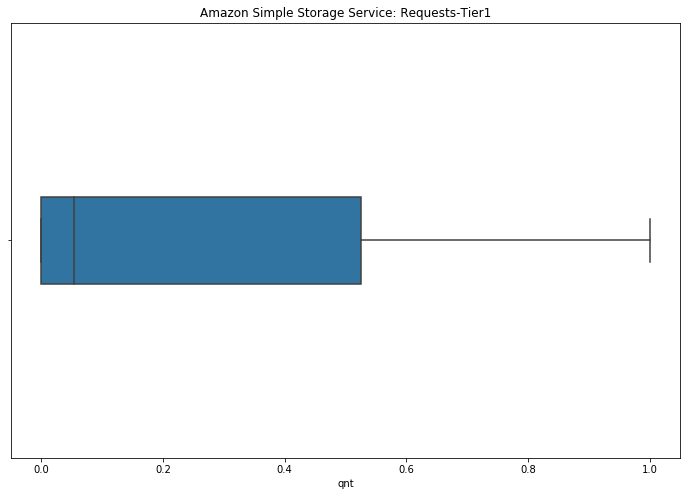

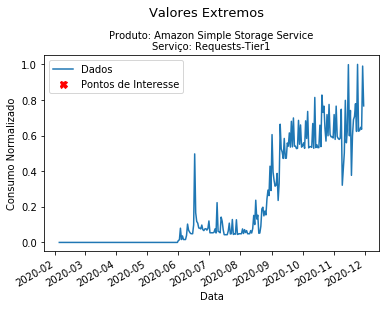

===  Amazon Simple Storage Service  /  Requests-Tier2  ====


<Figure size 432x288 with 0 Axes>

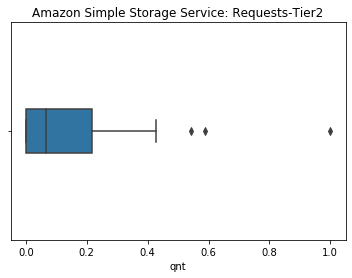

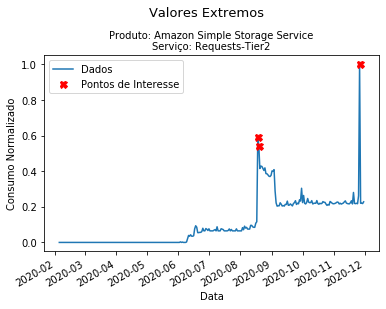

===  Amazon Simple Storage Service  /  SAE1-USE1-AWS-Out-Bytes  ====


<Figure size 432x288 with 0 Axes>

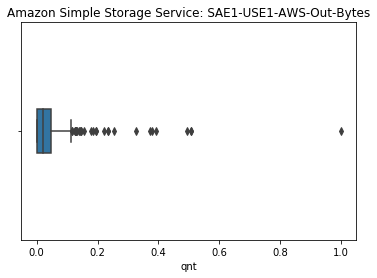

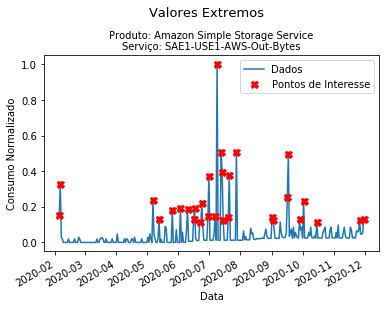

===  EC2 - Other  /  SAE1-DataTransfer-Regional-Bytes  ====


<Figure size 432x288 with 0 Axes>

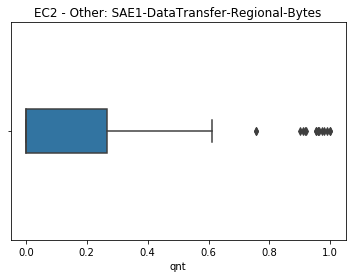

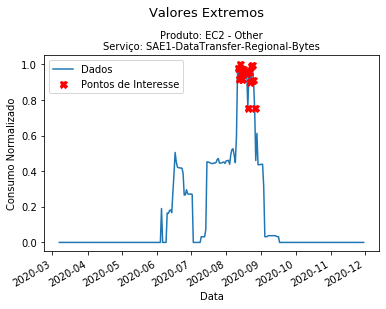

===  EC2 - Other  /  SAE1-EU-AWS-In-Bytes  ====


<Figure size 432x288 with 0 Axes>

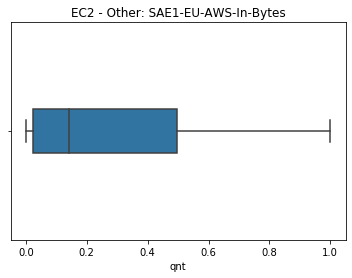

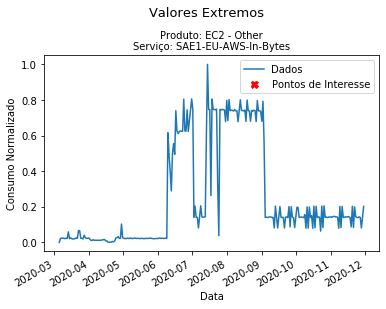

===  EC2 - Other  /  SAE1-NatGateway-Bytes  ====


<Figure size 432x288 with 0 Axes>

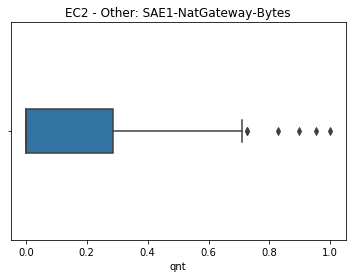

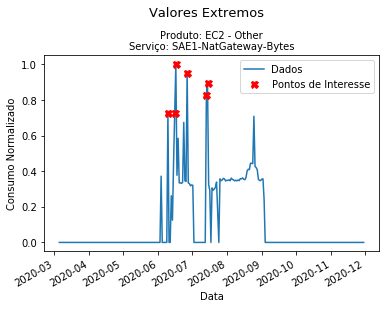

===  Amazon Virtual Private Cloud  /  SAE1-DataTransfer-In-Bytes  ====


<Figure size 432x288 with 0 Axes>

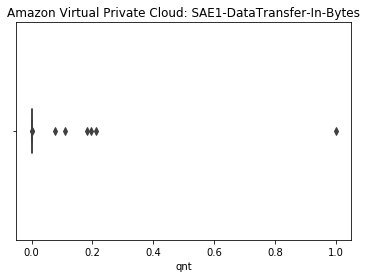

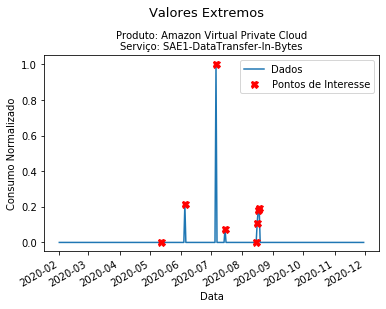

===  Amazon Virtual Private Cloud  /  SAE1-USW2-AWS-In-Bytes  ====


<Figure size 432x288 with 0 Axes>

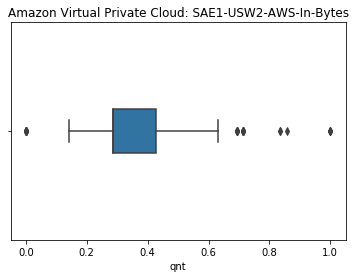

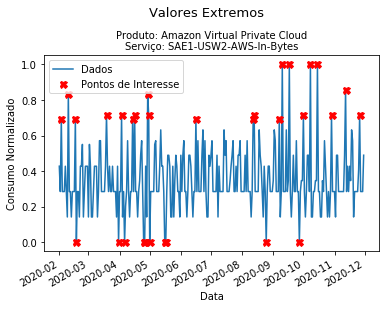

===  Amazon Virtual Private Cloud  /  SAE1-USE1-AWS-In-Bytes  ====


<Figure size 432x288 with 0 Axes>

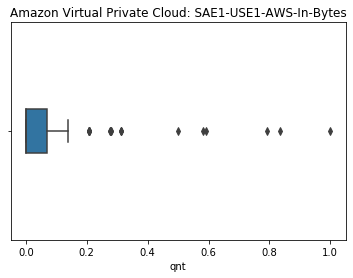

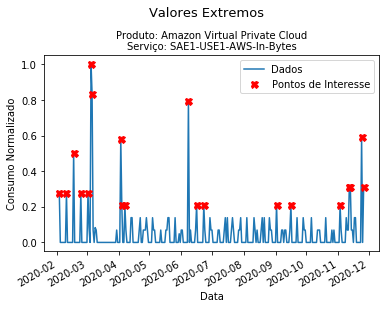

<Figure size 432x288 with 0 Axes>

In [29]:
for key in nuvem:
    for value in nuvem[key]:
        produto = key
        servico = value
        print('=== ',produto,' / ', servico,' ====')
        ddo_extremos (produto, servico)

## PROPHET <a name='prophet' />

In [30]:
def ddo_prophet(produto, servico, interval_width = 0.9, changepoint_range = 0.6):
    
    filename = "Series\serie_"+produto+"_"+servico+".csv"
    print(filename)
    data = pd.read_csv(filename)  
    
    data = data.rename(columns={"inicio": "ds", "qnt": "y"})
    
    
   
    m = Prophet(daily_seasonality = False, yearly_seasonality = False, weekly_seasonality = True,
                seasonality_mode = 'additive', 
                interval_width = interval_width,
                changepoint_range = changepoint_range,
#                 changepoint_prior_scale='30',
                growth='linear' #'logistic'
               )
    
    m = m.fit(data)
    
    
    forecast = m.predict(data)
    
#     fig1 = m.plot(forecast)
    
    
    
    forecast['fact'] = data['y'].reset_index(drop = True)
    
    forecasted = forecast[['ds','trend', 'yhat', 'yhat_lower', 'yhat_upper', 'fact']].copy()
    #forecast['fact'] = df['y']

    forecasted['anomaly'] = 0
    forecasted.loc[forecasted['fact'] > forecasted['yhat_upper'], 'anomaly'] = 1
    forecasted.loc[forecasted['fact'] < forecasted['yhat_lower'], 'anomaly'] = 1

    #anomaly importances
    forecasted['importance'] = 0
    forecasted.loc[forecasted['anomaly'] ==1, 'importance'] = \
        (forecasted['fact'] - forecasted['yhat_upper'])/forecast['fact']
    forecasted.loc[forecasted['anomaly'] ==-1, 'importance'] = \
        (forecasted['yhat_lower'] - forecasted['fact'])/forecast['fact']
    
    # limite_prophet = 0.6
    # avaliando acima de 0.2 ou 0.25... 0.6 talvez muito alto, outliers muito visíveis.... 
    # pred[(pred['anomaly']==1) & (pred['importance']>0.6)]

    outliers_prophet = pd.concat([forecasted[forecasted['anomaly']==1], forecasted[forecasted['anomaly']==-1]])
    outliers_prophet = outliers_prophet.rename(columns={"ds": "data", "anomaly": "prophet"})
    outliers_prophet_graph = outliers_prophet
    outliers_prophet = outliers_prophet.drop(columns=['trend', 'yhat', 'yhat_lower', 'yhat_upper', 'fact','importance'])
    outliers_prophet = outliers_prophet.data = outliers_prophet.set_index('data')
    
    
    
    #######################################Visualizando os gráficos
    plt.rcParams['figure.figsize'] = [6,4]
    fig, ax = plt.subplots()
    ax.plot(pd.to_datetime(data['ds']), data['y'], label='Dados')
    #rotacionando as datas
    #fig.autofmt_xdate(rotation=90)
    ax.plot(pd.to_datetime(data['ds']), forecasted['yhat'], label='Prophet')
    # marcando as anomalias em vermelho
    ax.plot(outliers_prophet_graph['data'], outliers_prophet_graph['fact'], 'rX', markersize=7, label='Pontos de Interesse')
    ax.set(xlabel='ds', ylabel='y',
           title=produto+': '+servico)
    
#     # marcando as anomalias do especialista
#     ax.plot(outliers.index, data[data['ds']== outliers.index]['y'], 'X', markersize=7, label='Outliers Especialista')
    
#     print(data)
#     print(outliers)
#     print(outliers.index)
#     print(data[data['ds']== outliers.index])
    
    #criando intervalo de confiança
    ax.fill_between(pd.to_datetime(data['ds']),forecasted['yhat_lower'],forecasted['yhat_upper'], alpha=0.2)
    
#     #removendo as datas do gráfico
#     plt.tick_params(
#         axis='x',          # changes apply to the x-axis
#         which='both',      # both major and minor ticks are affected
#         bottom=False,      # ticks along the bottom edge are off
#         top=False,         # ticks along the top edge are off
#         labelbottom=False) # labels along the bottom edge are off
#     #ax.grid()
    ax.legend()
    
    plt.suptitle('Prophet',y=1.05,fontsize=13)
    plt.title('Produto: '+produto+'\nServiço: '+servico,fontsize=10, loc='center')
        
    # Nomes dos eixos
    plt.xlabel('Data')
    plt.ylabel('Consumo Normalizado')
    
    #rotacionando os textos do eixo x
    fig.autofmt_xdate()
    
    #Salvando a figura
    filename = "Figuras\\"+produto+"_"+servico+"_prophet.png"
    plt.savefig(filename)
    
    plt.show()
    
    #gravando arquivo csv
    filename = "DdO\DdO_prophet_"+produto+"_"+servico+".csv"
    outliers_prophet.to_csv(filename,index = True, header=True)
    
    outliers_prophet
        
    return outliers_prophet, forecast, m

In [31]:
from fbprophet.plot import plot_plotly
import plotly.offline as py

In [32]:
# nuvem = {
#     'Amazon Virtual Private Cloud':['SAE1-DataTransfer-In-Bytes','SAE1-USW2-AWS-In-Bytes','SAE1-USE1-AWS-In-Bytes'],
#     'EC2 - Other':['SAE1-DataTransfer-Regional-Bytes','SAE1-EU-AWS-In-Bytes','SAE1-NatGateway-Bytes'],
#     'Amazon Simple Storage Service':['Requests-Tier1','Requests-Tier2','SAE1-USE1-AWS-Out-Bytes']
# }

## Figura Interativa <a name='fig' />

Series\serie_Amazon Simple Storage Service_Requests-Tier1.csv


INFO:numexpr.utils:NumExpr defaulting to 4 threads.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: UserWarning:

Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access



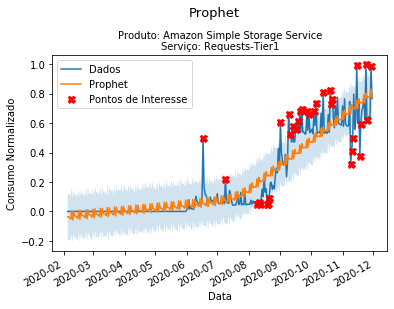

In [33]:
outliers_prophet, forecast, m = ddo_prophet('Amazon Simple Storage Service', 'Requests-Tier1')

py.init_notebook_mode()
fig = plot_plotly(m, forecast)  # This returns a plotly Figure
py.iplot(fig)

===  Amazon Simple Storage Service  /  Requests-Tier1  ====
Series\serie_Amazon Simple Storage Service_Requests-Tier1.csv


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: UserWarning:

Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access



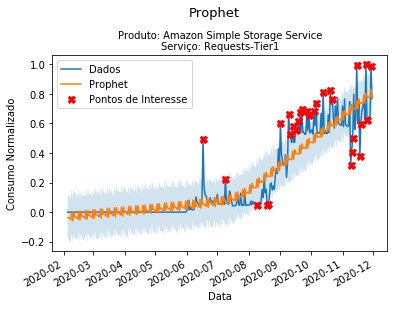

===  Amazon Simple Storage Service  /  Requests-Tier2  ====
Series\serie_Amazon Simple Storage Service_Requests-Tier2.csv


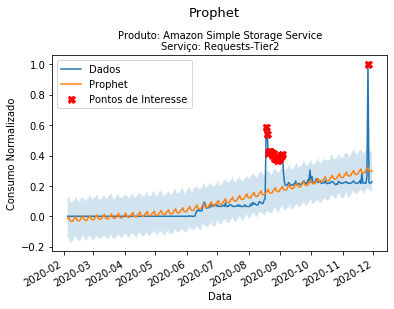

===  Amazon Simple Storage Service  /  SAE1-USE1-AWS-Out-Bytes  ====
Series\serie_Amazon Simple Storage Service_SAE1-USE1-AWS-Out-Bytes.csv


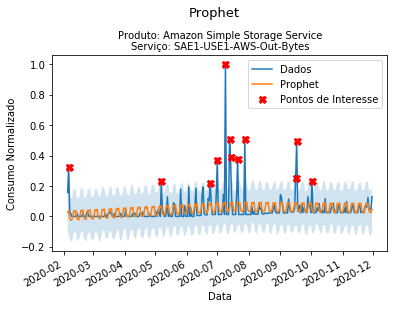

===  EC2 - Other  /  SAE1-DataTransfer-Regional-Bytes  ====
Series\serie_EC2 - Other_SAE1-DataTransfer-Regional-Bytes.csv


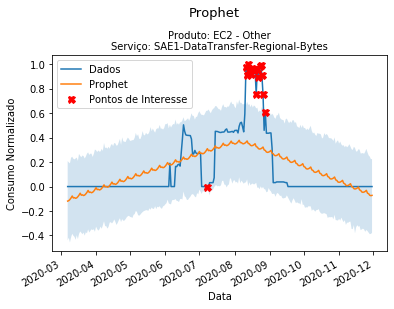

===  EC2 - Other  /  SAE1-EU-AWS-In-Bytes  ====
Series\serie_EC2 - Other_SAE1-EU-AWS-In-Bytes.csv


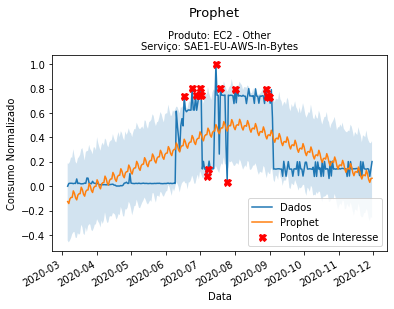

===  EC2 - Other  /  SAE1-NatGateway-Bytes  ====
Series\serie_EC2 - Other_SAE1-NatGateway-Bytes.csv


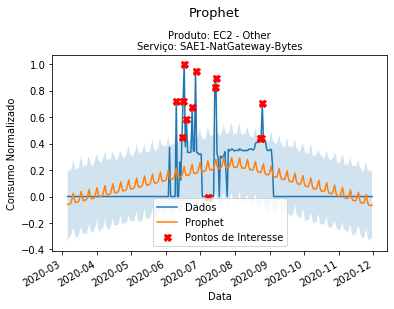

===  Amazon Virtual Private Cloud  /  SAE1-DataTransfer-In-Bytes  ====
Series\serie_Amazon Virtual Private Cloud_SAE1-DataTransfer-In-Bytes.csv


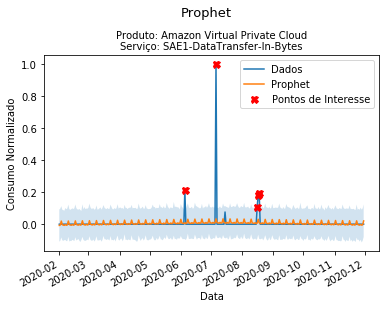

===  Amazon Virtual Private Cloud  /  SAE1-USW2-AWS-In-Bytes  ====
Series\serie_Amazon Virtual Private Cloud_SAE1-USW2-AWS-In-Bytes.csv


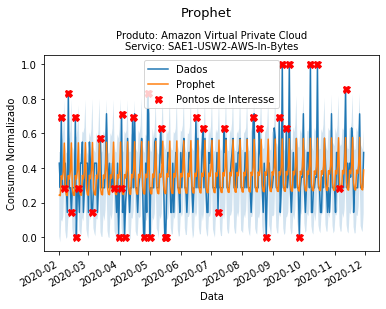

===  Amazon Virtual Private Cloud  /  SAE1-USE1-AWS-In-Bytes  ====
Series\serie_Amazon Virtual Private Cloud_SAE1-USE1-AWS-In-Bytes.csv


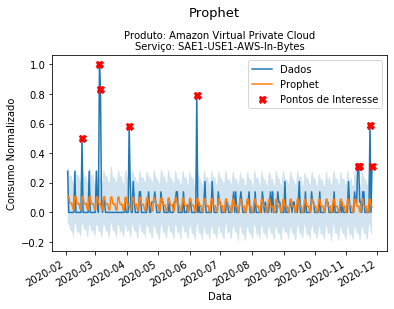

In [34]:

for key in nuvem:
    for value in nuvem[key]:
        produto = key
        servico = value
        print('=== ',produto,' / ', servico,' ====')
        ddo_prophet (produto, servico)
        

# Holt-Winters <a name='hw' />

In [35]:
def ddo_holt_winters(produto, servico, limite=0.25, trend = 'add', seasonal='add', seasonal_periods=7):
    
    filename = "Series\serie_"+produto+"_"+servico+".csv"
    data = pd.read_csv(filename, index_col=0) 
    
    
    
    modelo_hw =  ExponentialSmoothing(data['qnt'], trend=trend, seasonal=seasonal, seasonal_periods=seasonal_periods);
    ajustado_hw = modelo_hw.fit(); # testar parâmetros
    
#     ajustado_hw.summary()
    
    
    #identificando os outliers
    data['ajustado'] = ajustado_hw.fittedvalues
    data['diff'] = abs(data['qnt']- data['ajustado'])
    outliers_hw = data[data['diff']>limite]
    
    #Visualizando os gráficos
    plt.rcParams['figure.figsize'] = [6,4]
    fig, ax = plt.subplots()
    ax.plot(pd.to_datetime(data['inicio']), data['qnt'], label='Dados')
    #rotacionando as datas
    #fig.autofmt_xdate(rotation=90)
    ax.plot(pd.to_datetime(data['inicio']), ajustado_hw.fittedvalues, label='Holt_Winters')
    # marcando as anomalias em vermelho
    ax.plot(pd.to_datetime(outliers_hw['inicio']), outliers_hw['qnt'], 'rX', markersize=7,label='Pontos de Interesse') 
    ax.set(xlabel='data', ylabel='qnt',
#            title=produto+': '+servico
          )
    #removendo as datas do gráfico
#     plt.tick_params(
#         axis='x',          # changes apply to the x-axis
#         which='both',      # both major and minor ticks are affected
#         bottom=False,      # ticks along the bottom edge are off
#         top=False,         # ticks along the top edge are off
#         labelbottom=False) # labels along the bottom edge are off
    #ax.grid()
    ax.legend()
    
    plt.suptitle('Holt-Winters',y=1.05,fontsize=13)
    plt.title('Produto: '+produto+'\nServiço: '+servico,fontsize=10, loc='center')
        
    # Nomes dos eixos
    plt.xlabel('Data')
    plt.ylabel('Consumo Normalizado')
    
    #rotacionando os textos do eixo x
    fig.autofmt_xdate()
    
    #Salvando a figura
    filename = "Figuras\\"+produto+"_"+servico+"_hw.png"
    plt.savefig(filename)
    
    
    
    plt.show()

  
    outliers_hw = outliers_hw.rename(columns={"inicio": "data"})
    outliers_hw['holt-winters']=1
    outliers_hw = outliers_hw.drop(columns=['qnt', 'ajustado', 'diff'])
    outliers_hw = outliers_hw.set_index('data')
    
       
    #gravando arquivo csv
    filename = "DdO\DdO_holt-winters_"+produto+"_"+servico+".csv"
    outliers_hw.to_csv(filename,index = True, header=True)
            
    return outliers_hw

===  Amazon Simple Storage Service  /  Requests-Tier1  ====


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:725: RuntimeWarning:

invalid value encountered in less_equal

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:731: RuntimeWarning:

invalid value encountered in greater_equal



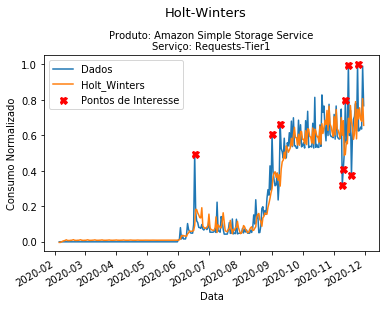

===  Amazon Simple Storage Service  /  Requests-Tier2  ====


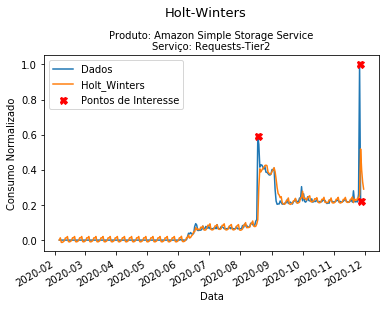

===  Amazon Simple Storage Service  /  SAE1-USE1-AWS-Out-Bytes  ====


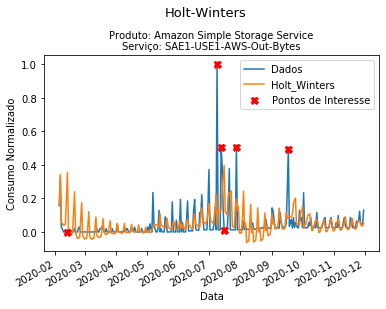

===  EC2 - Other  /  SAE1-DataTransfer-Regional-Bytes  ====


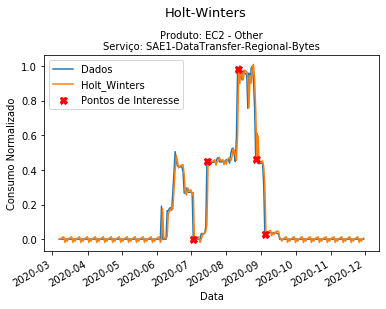

===  EC2 - Other  /  SAE1-EU-AWS-In-Bytes  ====


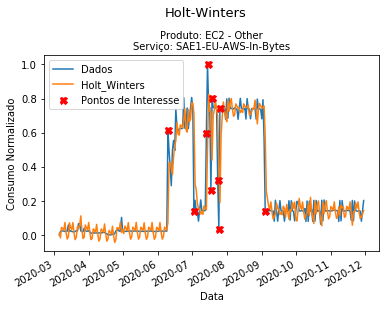

===  EC2 - Other  /  SAE1-NatGateway-Bytes  ====


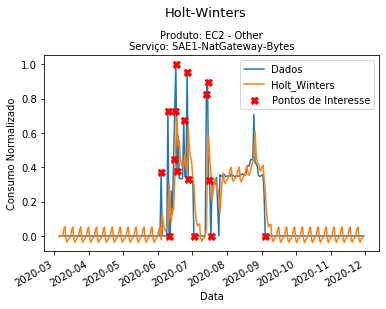

===  Amazon Virtual Private Cloud  /  SAE1-DataTransfer-In-Bytes  ====


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.



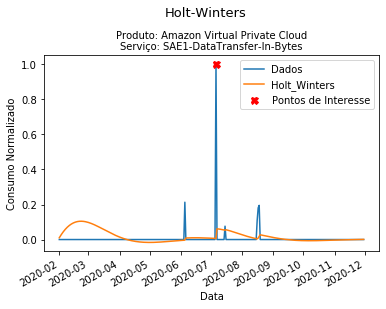

===  Amazon Virtual Private Cloud  /  SAE1-USW2-AWS-In-Bytes  ====


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.



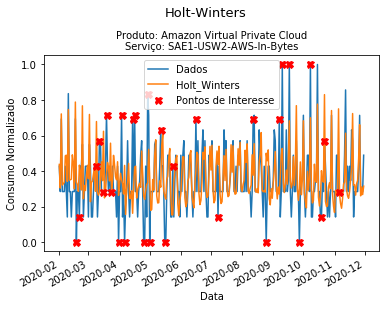

===  Amazon Virtual Private Cloud  /  SAE1-USE1-AWS-In-Bytes  ====


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.



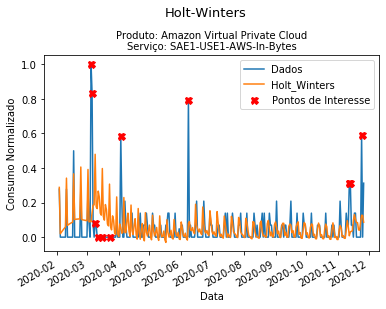

In [36]:
for key in nuvem:
    for value in nuvem[key]:
        produto = key
        servico = value
        print('=== ',produto,' / ', servico,' ====')
        ddo_holt_winters(produto, servico)

# SARIMA <a name='sarima' />

In [37]:
def ddo_sarima(produto, servico, limite_sarima =0.2, max_p=6, max_q=6, m=7):
    
    filename = "Series\serie_"+produto+"_"+servico+".csv"
    data = pd.read_csv(filename, index_col=0) 
    
    #criando o modelo
    stepwise_fit = auto_arima(data['qnt'], start_p=0, start_q=0,
                          max_p=10, max_q=10, m=7,
                          seasonal=True,
                          trace=True,
                          error_action='ignore',   # we don't want to know if an order does not work
                          suppress_warnings=True,  # we don't want convergence warnings
                          stepwise=True)           # set to stepwise
#     stepwise_fit.summary()
    
    
    modelo = SARIMAX(data['qnt'],order=stepwise_fit.order,seasonal_order=stepwise_fit.seasonal_order, enforce_stationarity=False)
    resultado = modelo.fit()
    
    predicted = resultado.predict(dynamic=False, typ='levels').rename('SARIMAX')
    predicted.index = data.index
    
    #identificando os outliers
    data['ajustado'] = predicted
    data['diff'] = abs(data['qnt']- data['ajustado'])
    
    outliers_sarima = data[data['diff']>limite_sarima]
    
    #Visualizando os gráficos
#     ylabel='Valor'
#     xlabel='Data'
#     ax = data['qnt'].plot(legend=True,figsize=(8,4), label='Dados')
#     predicted.plot(legend=True)
#     ax.autoscale(axis='x',tight=True)
#     ax.set(xlabel=xlabel, ylabel=ylabel);

    plt.rcParams['figure.figsize'] = [6,4]
    fig, ax = plt.subplots()
    ax.plot(pd.to_datetime(data['inicio']), data['qnt'], label='Dados')
    ax.plot(pd.to_datetime(data['inicio']), predicted, label='SARIMA')
    # marcando as anomalias em vermelho
    ax.plot(pd.to_datetime(outliers_sarima['inicio']), outliers_sarima['qnt'], 'rX', markersize=7, label='Pontos de Interesse') 
    ax.set(xlabel='data', ylabel='qnt',
           title=produto+': '+servico)
    #removendo as datas do gráfico
#     plt.tick_params(
#         axis='x',          # changes apply to the x-axis
#         which='both',      # both major and minor ticks are affected
#         bottom=False,      # ticks along the bottom edge are off
#         top=False,         # ticks along the top edge are off
#         labelbottom=False) # labels along the bottom edge are off
    #ax.grid()
    ax.legend()
    
    plt.suptitle('SARIMA',y=1.05,fontsize=13)
    plt.title('Produto: '+produto+'\nServiço: '+servico,fontsize=10, loc='center')
        
    # Nomes dos eixos
    plt.xlabel('Data')
    plt.ylabel('Consumo Normalizado')
    
    #rotacionando os textos do eixo x
    fig.autofmt_xdate()
    
    #Salvando a figura
    filename = "Figuras\\"+produto+"_"+servico+"_sarima.png"
    plt.savefig(filename)
    
    plt.show()
    
    
    
    outliers_sarima = outliers_sarima.rename(columns={"inicio": "data"})
    outliers_sarima['sarima']=1
    outliers_sarima = outliers_sarima.drop(columns=['qnt', 'ajustado', 'diff'])
    outliers_sarima = outliers_sarima.set_index('data')
    
       
    #gravando arquivo csv
    filename = "DdO\DdO_sarima_"+produto+"_"+servico+".csv"
    outliers_sarima.to_csv(filename,index = True, header=True)
            
    return outliers_sarima

===  Amazon Simple Storage Service  /  Requests-Tier1  ====
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,0,1)[7] intercept   : AIC=-653.805, Time=0.63 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=-518.372, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=-654.780, Time=0.25 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=-687.977, Time=0.35 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=-520.180, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[7] intercept   : AIC=-661.650, Time=0.07 sec
 ARIMA(0,1,1)(1,0,1)[7] intercept   : AIC=-713.368, Time=0.64 sec
 ARIMA(0,1,1)(1,0,0)[7] intercept   : AIC=-699.537, Time=0.32 sec
 ARIMA(0,1,1)(2,0,1)[7] intercept   : AIC=-712.206, Time=1.24 sec
 ARIMA(0,1,1)(1,0,2)[7] intercept   : AIC=-713.794, Time=2.01 sec
 ARIMA(0,1,1)(0,0,2)[7] intercept   : AIC=-697.689, Time=1.30 sec
 ARIMA(0,1,1)(2,0,2)[7] intercept   : AIC=-714.423, Time=1.44 sec
 ARIMA(0,1,0)(2,0,2)[7] intercept   : AIC=-651.138, Time=1.39 sec
 ARIMA(1,1,1)(2,0,2)[7] intercept   : A

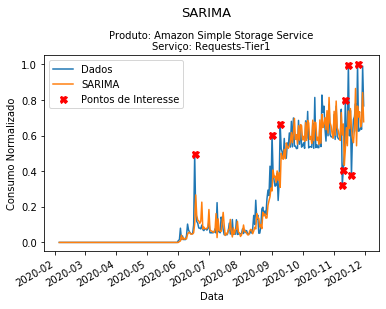

===  Amazon Simple Storage Service  /  Requests-Tier2  ====
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,0,1)[7] intercept   : AIC=-736.463, Time=0.30 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=-739.074, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=-784.141, Time=0.23 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=-815.291, Time=0.34 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=-741.038, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[7] intercept   : AIC=-817.290, Time=0.10 sec
 ARIMA(0,1,1)(1,0,0)[7] intercept   : AIC=-815.292, Time=0.26 sec
 ARIMA(0,1,1)(1,0,1)[7] intercept   : AIC=-813.291, Time=0.24 sec
 ARIMA(1,1,1)(0,0,0)[7] intercept   : AIC=-818.011, Time=0.16 sec
 ARIMA(1,1,1)(1,0,0)[7] intercept   : AIC=-816.011, Time=0.45 sec
 ARIMA(1,1,1)(0,0,1)[7] intercept   : AIC=-816.011, Time=1.04 sec
 ARIMA(1,1,1)(1,0,1)[7] intercept   : AIC=-814.012, Time=0.59 sec
 ARIMA(1,1,0)(0,0,0)[7] intercept   : AIC=-786.117, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[7] intercept   : A

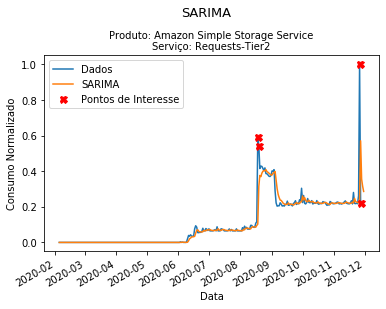

===  Amazon Simple Storage Service  /  SAE1-USE1-AWS-Out-Bytes  ====
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,0,1)[7] intercept   : AIC=-409.950, Time=0.31 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=-412.591, Time=0.10 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=-476.086, Time=0.19 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=-580.221, Time=0.45 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=-414.591, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[7] intercept   : AIC=-575.351, Time=0.10 sec
 ARIMA(0,1,1)(1,0,1)[7] intercept   : AIC=inf, Time=1.00 sec
 ARIMA(0,1,1)(0,0,2)[7] intercept   : AIC=-583.166, Time=1.19 sec
 ARIMA(0,1,1)(1,0,2)[7] intercept   : AIC=-582.402, Time=1.19 sec
 ARIMA(0,1,0)(0,0,2)[7] intercept   : AIC=-409.716, Time=0.21 sec
 ARIMA(1,1,1)(0,0,2)[7] intercept   : AIC=-581.308, Time=1.16 sec
 ARIMA(0,1,2)(0,0,2)[7] intercept   : AIC=-581.640, Time=1.38 sec
 ARIMA(1,1,0)(0,0,2)[7] intercept   : AIC=-475.347, Time=0.36 sec
 ARIMA(1,1,2)(0,0,2)[7] intercept  

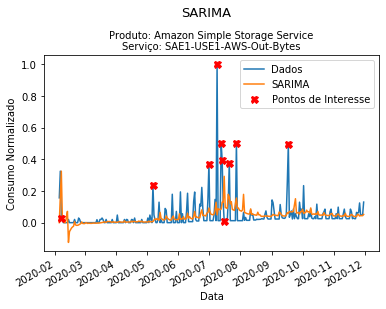

===  EC2 - Other  /  SAE1-DataTransfer-Regional-Bytes  ====
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,0,1)[7] intercept   : AIC=-751.225, Time=0.30 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=-750.390, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=-748.338, Time=0.23 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=-748.693, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=-752.390, Time=0.02 sec
 ARIMA(0,1,0)(1,0,0)[7] intercept   : AIC=-750.116, Time=0.11 sec
 ARIMA(0,1,0)(0,0,1)[7] intercept   : AIC=-750.473, Time=0.18 sec
 ARIMA(1,1,0)(0,0,0)[7] intercept   : AIC=-748.503, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[7] intercept   : AIC=-748.487, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[7] intercept   : AIC=-746.904, Time=0.24 sec

Best model:  ARIMA(0,1,0)(0,0,0)[7]          
Total fit time: 1.341 seconds


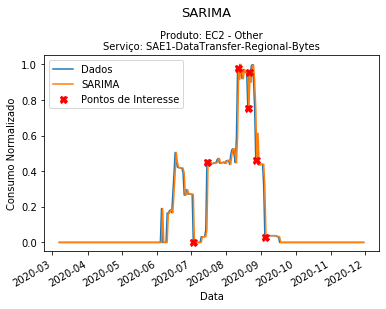

===  EC2 - Other  /  SAE1-EU-AWS-In-Bytes  ====
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,0,1)[7] intercept   : AIC=-410.285, Time=0.32 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=-401.899, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=-422.260, Time=0.13 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=-425.320, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=-403.888, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[7] intercept   : AIC=-417.407, Time=0.06 sec
 ARIMA(0,1,1)(1,0,1)[7] intercept   : AIC=-426.924, Time=0.54 sec
 ARIMA(0,1,1)(1,0,0)[7] intercept   : AIC=-426.068, Time=0.23 sec
 ARIMA(0,1,1)(2,0,1)[7] intercept   : AIC=-426.252, Time=1.04 sec
 ARIMA(0,1,1)(1,0,2)[7] intercept   : AIC=-426.372, Time=1.05 sec
 ARIMA(0,1,1)(0,0,2)[7] intercept   : AIC=-423.705, Time=0.43 sec
 ARIMA(0,1,1)(2,0,0)[7] intercept   : AIC=-424.453, Time=0.44 sec
 ARIMA(0,1,1)(2,0,2)[7] intercept   : AIC=-426.984, Time=1.21 sec
 ARIMA(0,1,0)(2,0,2)[7] intercept   : AIC=-411.596,

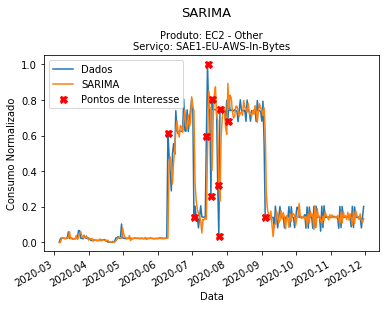

===  EC2 - Other  /  SAE1-NatGateway-Bytes  ====
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,0,1)[7] intercept   : AIC=-312.843, Time=0.49 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=-312.033, Time=0.04 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=-342.403, Time=0.24 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=-363.085, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=-314.033, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[7] intercept   : AIC=-360.411, Time=0.06 sec
 ARIMA(0,1,1)(1,0,1)[7] intercept   : AIC=-364.296, Time=0.76 sec
 ARIMA(0,1,1)(1,0,0)[7] intercept   : AIC=-363.749, Time=0.21 sec
 ARIMA(0,1,1)(2,0,1)[7] intercept   : AIC=-362.246, Time=1.09 sec
 ARIMA(0,1,1)(1,0,2)[7] intercept   : AIC=-363.090, Time=1.12 sec
 ARIMA(0,1,1)(0,0,2)[7] intercept   : AIC=-362.826, Time=0.58 sec
 ARIMA(0,1,1)(2,0,0)[7] intercept   : AIC=-362.573, Time=0.54 sec
 ARIMA(0,1,1)(2,0,2)[7] intercept   : AIC=-360.539, Time=1.32 sec
 ARIMA(1,1,1)(1,0,1)[7] intercept   : AIC=-366.513

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



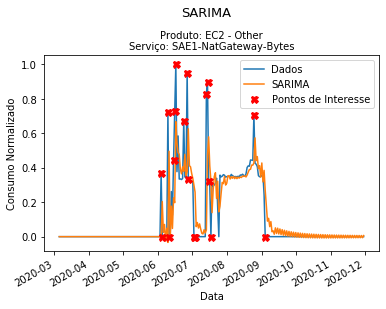

===  Amazon Virtual Private Cloud  /  SAE1-DataTransfer-In-Bytes  ====
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,0,1)[7] intercept   : AIC=-831.868, Time=0.10 sec
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=-835.831, Time=0.05 sec
 ARIMA(1,0,0)(1,0,0)[7] intercept   : AIC=-832.334, Time=0.12 sec
 ARIMA(0,0,1)(0,0,1)[7] intercept   : AIC=-832.325, Time=0.24 sec
 ARIMA(0,0,0)(0,0,0)[7]             : AIC=-835.040, Time=0.02 sec
 ARIMA(0,0,0)(1,0,0)[7] intercept   : AIC=-833.858, Time=0.09 sec
 ARIMA(0,0,0)(0,0,1)[7] intercept   : AIC=-833.858, Time=0.08 sec
 ARIMA(1,0,0)(0,0,0)[7] intercept   : AIC=-834.311, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[7] intercept   : AIC=-834.302, Time=0.06 sec
 ARIMA(1,0,1)(0,0,0)[7] intercept   : AIC=-832.323, Time=0.13 sec

Best model:  ARIMA(0,0,0)(0,0,0)[7] intercept
Total fit time: 0.930 seconds


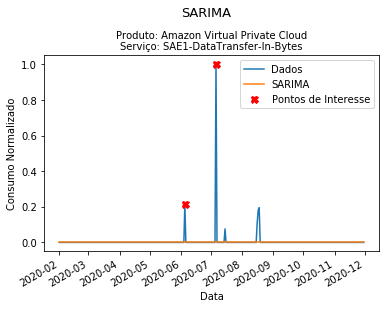

===  Amazon Virtual Private Cloud  /  SAE1-USW2-AWS-In-Bytes  ====
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,0,1)[7] intercept   : AIC=-263.697, Time=0.40 sec
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=-180.176, Time=0.12 sec
 ARIMA(1,0,0)(1,0,0)[7] intercept   : AIC=-256.394, Time=0.32 sec
 ARIMA(0,0,1)(0,0,1)[7] intercept   : AIC=-229.718, Time=0.14 sec
 ARIMA(0,0,0)(0,0,0)[7]             : AIC=305.362, Time=0.02 sec
 ARIMA(0,0,0)(0,0,1)[7] intercept   : AIC=-231.617, Time=0.18 sec
 ARIMA(0,0,0)(1,0,0)[7] intercept   : AIC=-258.337, Time=0.22 sec
 ARIMA(0,0,0)(2,0,1)[7] intercept   : AIC=-295.989, Time=0.99 sec
 ARIMA(0,0,0)(2,0,0)[7] intercept   : AIC=-274.549, Time=0.67 sec
 ARIMA(0,0,0)(2,0,2)[7] intercept   : AIC=-294.096, Time=1.37 sec
 ARIMA(0,0,0)(1,0,2)[7] intercept   : AIC=-295.993, Time=1.26 sec
 ARIMA(0,0,0)(0,0,2)[7] intercept   : AIC=-243.436, Time=0.57 sec
 ARIMA(1,0,0)(1,0,2)[7] intercept   : AIC=-290.684, Time=1.41 sec
 ARIMA(0,0,1)(1,0,2)[7] intercept

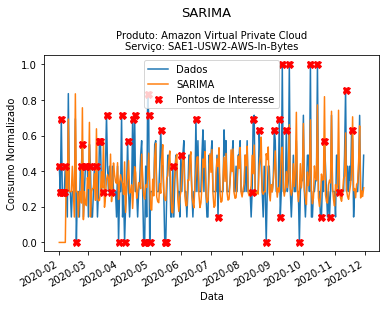

===  Amazon Virtual Private Cloud  /  SAE1-USE1-AWS-In-Bytes  ====
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,0,1)[7] intercept   : AIC=-431.849, Time=0.52 sec
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=-423.462, Time=0.05 sec
 ARIMA(1,0,0)(1,0,0)[7] intercept   : AIC=-435.281, Time=0.28 sec
 ARIMA(0,0,1)(0,0,1)[7] intercept   : AIC=-435.330, Time=0.12 sec
 ARIMA(0,0,0)(0,0,0)[7]             : AIC=-375.864, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[7] intercept   : AIC=-434.368, Time=0.09 sec
 ARIMA(0,0,1)(1,0,1)[7] intercept   : AIC=-442.444, Time=0.58 sec
 ARIMA(0,0,1)(1,0,0)[7] intercept   : AIC=-435.950, Time=0.19 sec
 ARIMA(0,0,1)(2,0,1)[7] intercept   : AIC=-440.465, Time=1.10 sec
 ARIMA(0,0,1)(1,0,2)[7] intercept   : AIC=-440.465, Time=1.03 sec
 ARIMA(0,0,1)(0,0,2)[7] intercept   : AIC=-435.674, Time=0.44 sec
 ARIMA(0,0,1)(2,0,0)[7] intercept   : AIC=-437.047, Time=0.28 sec
 ARIMA(0,0,1)(2,0,2)[7] intercept   : AIC=-438.507, Time=1.70 sec
 ARIMA(1,0,1)(1,0,1)[7] intercep

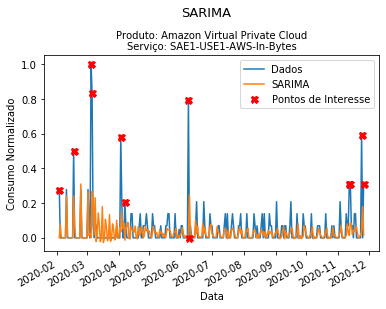

In [38]:
for key in nuvem:
    for value in nuvem[key]:
        produto = key
        servico = value
        print('=== ',produto,' / ', servico,' ====')
        ddo_sarima(produto, servico)

# DBSCAN <a name='dbscan' />

In [39]:
def ddo_dbscan(produto, servico, eps=0.05, min_samples=3):
    
    filename = "Series\serie_"+produto+"_"+servico+".csv"
    data = pd.read_csv(filename, index_col=0) 
    
    # adaptando o dbscan para séries temporais, transformando as datas em inteiros
    data["inicio"] = pd.to_datetime(data["inicio"]).astype(np.int64)
    
    #normalizando os dados
    scaler_qnt = MinMaxScaler()    
    scaler_qnt.fit(np.array(data['qnt']).reshape(-1,1))
    data['qnt'] = scaler_qnt.transform(np.array(data['qnt']).reshape(-1,1))
    
    scaler_inicio = MinMaxScaler()
    scaler_inicio.fit(np.array(data['inicio']).reshape(-1,1))
    data['inicio'] = scaler_inicio.transform(np.array(data['inicio']).reshape(-1,1))
        
    #criando o modelo
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    clusters = dbscan.fit_predict(data)
    labels = dbscan.labels_

    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)

    print('Estimated number of clusters: %d' % n_clusters_)
    print('Estimated number of noise points: %d' % n_noise_)
    
    # as anomalias serão indicadas como -1 na variável 'clusters'
    data['clusters']=clusters
    
    
    #voltando o valor da data de inteiro para date
    data['qnt'] = scaler_qnt.inverse_transform(np.array(data['qnt']).reshape(-1,1))
    data['inicio'] = scaler_inicio.inverse_transform(np.array(data['inicio']).reshape(-1,1))
    data["inicio"] = pd.to_datetime(data["inicio"])
    data['inicio'] = data['inicio'].dt.date
    
    #classificando os dados de acordo com a coluna de datas "inicio"
    data =  data.sort_values(by="inicio")
    
    outliers_dbscan = data[data['clusters']==-1]
    
    # plot the cluster assignments
#     plt.scatter(data['inicio'], data['qnt'], c=clusters, cmap="plasma")
#     plt.xlabel("Feature 0")
#     plt.ylabel("Feature 1")
    

    plt.rcParams['figure.figsize'] = [6,4]
    fig, ax = plt.subplots()
#     ax.plot(data['inicio'], data['qnt'], label='Dados')
#     ax.plot(data['inicio'], predicted, label='SARIMA')
#     plt.scatter(data['inicio'], data['qnt'], c=clusters, cmap="tab20b")
    plt.scatter(data['inicio'], data['qnt'], c=clusters, cmap="winter", label ='clusters')
    
    # marcando as anomalias em vermelho
    ax.plot(outliers_dbscan['inicio'], outliers_dbscan['qnt'], 'rX', markersize=10, label='outlier') 
    ax.set(xlabel='Data', ylabel='Consumo Normalizado',
#            title='DBSCAN - Nº de clusters: '+str(n_clusters_)+'\n'+produto+': '+servico
          )
    #removendo as datas do gráfico
    plt.tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=False) # labels along the bottom edge are off
    #ax.grid()
    #inclinando os textos do eixo x
    fig.autofmt_xdate()

    ax.legend() 
    
    plt.suptitle('DBSCAN - Nº de clusters: '+str(n_clusters_),y=1.05,fontsize=13)
    plt.title('Produto: '+produto+'\nServiço: '+servico,fontsize=10, loc='center')


    #Salvando a figura
    filename = "Figuras\\"+produto+"_"+servico+"_dbscan.png"
    plt.savefig(filename)

    plt.show()
    
    
    
    outliers_dbscan = outliers_dbscan.rename(columns={"inicio": "data", "clusters": "DBSCAN"})
    outliers_dbscan['DBSCAN']=1
    outliers_dbscan = outliers_dbscan.drop(columns=['qnt'])
    outliers_dbscan = outliers_dbscan.set_index('data')
    
       
    #gravando arquivo csv
    filename = "DdO\DdO_DBSCAN_"+produto+"_"+servico+".csv"
    outliers_dbscan.to_csv(filename,index = True, header=True)
            
    return outliers_dbscan

===  Amazon Simple Storage Service  /  Requests-Tier1  ====
Estimated number of clusters: 3
Estimated number of noise points: 9


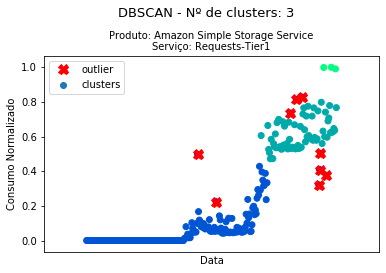

===  Amazon Simple Storage Service  /  Requests-Tier2  ====
Estimated number of clusters: 3
Estimated number of noise points: 4


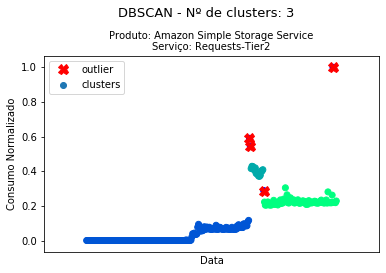

===  Amazon Simple Storage Service  /  SAE1-USE1-AWS-Out-Bytes  ====
Estimated number of clusters: 5
Estimated number of noise points: 9


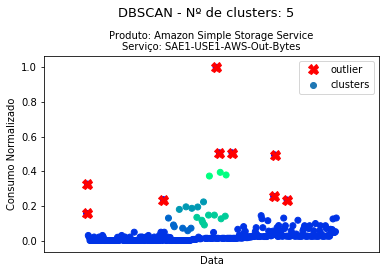

===  EC2 - Other  /  SAE1-DataTransfer-Regional-Bytes  ====
Estimated number of clusters: 9
Estimated number of noise points: 6


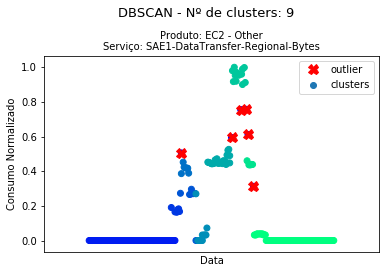

===  EC2 - Other  /  SAE1-EU-AWS-In-Bytes  ====
Estimated number of clusters: 12
Estimated number of noise points: 16


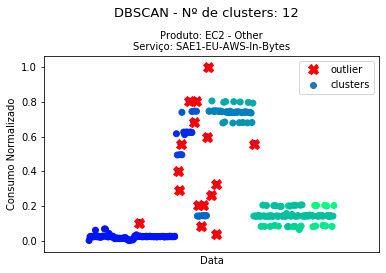

===  EC2 - Other  /  SAE1-NatGateway-Bytes  ====
Estimated number of clusters: 5
Estimated number of noise points: 15


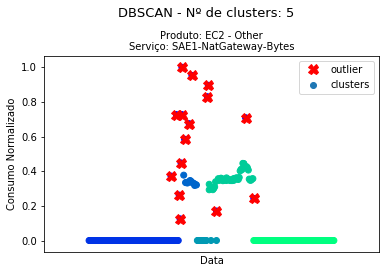

===  Amazon Virtual Private Cloud  /  SAE1-DataTransfer-In-Bytes  ====
Estimated number of clusters: 1
Estimated number of noise points: 6


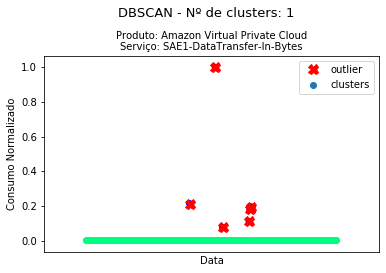

===  Amazon Virtual Private Cloud  /  SAE1-USW2-AWS-In-Bytes  ====
Estimated number of clusters: 20
Estimated number of noise points: 40


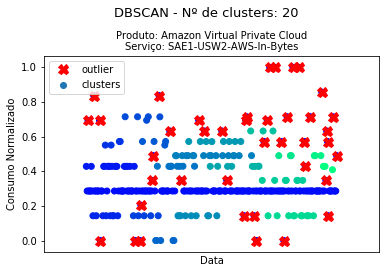

===  Amazon Virtual Private Cloud  /  SAE1-USE1-AWS-In-Bytes  ====
Estimated number of clusters: 10
Estimated number of noise points: 14


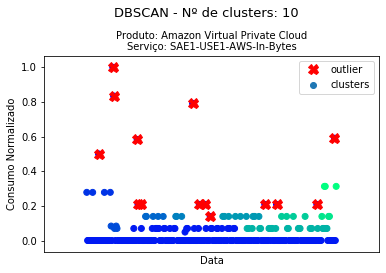

In [40]:
for key in nuvem:
    for value in nuvem[key]:
        produto = key
        servico = value
        print('=== ',produto,' / ', servico,' ====')
        ddo_dbscan(produto, servico)

# LOF <a name='lof' />

In [41]:
def ddo_lof(produto, servico, n_neighbors=20, metric="minkowski", limite=-1.7):
    
    filename = "Series\serie_"+produto+"_"+servico+".csv"
    data = pd.read_csv(filename, index_col=0)
    
    # adaptando o dbscan para séries temporais, transformando as datas em inteiros
    data["inicio"] = pd.to_datetime(data["inicio"]).astype(np.int64)
    
    #normalizando os dados
    scaler_qnt = MinMaxScaler()    
    scaler_qnt.fit(np.array(data['qnt']).reshape(-1,1))
    data['qnt'] = scaler_qnt.transform(np.array(data['qnt']).reshape(-1,1))
    
    scaler_inicio = MinMaxScaler()
    scaler_inicio.fit(np.array(data['inicio']).reshape(-1,1))
    data['inicio'] = scaler_inicio.transform(np.array(data['inicio']).reshape(-1,1))
    
    #criando o modelo
    X = data.values
    vizinhos = round(len(data))

    # fit the model for outlier detection (default)
    clf = LocalOutlierFactor(n_neighbors=n_neighbors, metric=metric)
    
    # use fit_predict to compute the predicted labels of the training samples
    # (when LOF is used for outlier detection, the estimator has no predict,
    # decision_function and score_samples methods).
    y_pred = clf.fit_predict(data)
    
    # n_errors = (y_pred != ground_truth).sum()
    X_scores = clf.negative_outlier_factor_

    
    
    # O valor de y_pred será -1 para os outliers
    data['pred'] = y_pred
    data['lof_scores'] = X_scores
    
    
    
    # Os outliers com valores abaixo do limite estipulado serão marcados com o valor 0
    data['pred'].loc[(data['pred']== -1) & (data['lof_scores']<limite)] = 0
    
    outliers_graf = data[data['pred']==0]
    
    
    #voltando o valor da data de inteiro para date
    data['qnt'] = scaler_qnt.inverse_transform(np.array(data['qnt']).reshape(-1,1))
    data['inicio'] = scaler_inicio.inverse_transform(np.array(data['inicio']).reshape(-1,1))
    data["inicio"] = pd.to_datetime(data["inicio"])
    data['inicio'] = data['inicio'].dt.date
    
    #classificando os dados de acordo com a coluna de datas "inicio"
    data =  data.sort_values(by="inicio")
    
    outliers_lof= data[data['pred']==0]
    
#     plt.rcParams['figure.figsize'] = [6,4]
    plt.figure(figsize=(6, 4))
    
    
    
    #visualizando os outliers
#     plt.title("Local Outlier Factor (LOF)")
    plt.scatter(X[:, 0], X[:, 1], color='k', s=3., label='Dados')
    # plot circles with radius proportional to the outlier scores
    radius = (X_scores.max() - X_scores) / (X_scores.max() - X_scores.min())
    
    
#     plt.scatter(X[:, 0], X[:, 1], s=1000 * radius, edgecolors='r',
#                 facecolors='none', label='Outlier scores')
    
    plt.scatter(outliers_graf['inicio'], outliers_graf['qnt'], s=1000 * radius, edgecolors='r',
                facecolors='none', label='Outlier')
    
    
#     plt.axis('tight')
    # plt.xlim((-5, 5))
    # plt.ylim((-5, 5))
    # plt.xlabel("prediction errors: %d" % (n_errors))
    legend = plt.legend(loc='best')
    legend.legendHandles[0]._sizes = [10]
    legend.legendHandles[1]._sizes = [20]
    
    
    plt.suptitle('LOF',y=1.05,fontsize=13)
    plt.title('Produto: '+produto+'\nServiço: '+servico,fontsize=10, loc='center')
        
    # Nomes dos eixos
    plt.xlabel('Data')
    plt.ylabel('Consumo Normalizado')
    
    #Salvando a figura
    filename = "Figuras\\"+produto+"_"+servico+"_lof.png"
    plt.savefig(filename)
    
    plt.show()



#     fig, ax = plt.subplots()
# #     ax.plot(data['inicio'], data['qnt'], label='Dados')
# #     ax.plot(data['inicio'], predicted, label='SARIMA')
# #     plt.scatter(data['inicio'], data['qnt'], c=clusters, cmap="tab20b")
#     plt.scatter(data['inicio'], data['qnt'], c=clusters, cmap="winter")
    
#     # marcando as anomalias em vermelho
#     ax.plot(outliers_lof['inicio'], outliers_lof['qnt'], 'rX', markersize=10) 
#     ax.set(xlabel='data', ylabel='qnt',
#            title=produto+': '+servico)
#     #removendo as datas do gráfico
#     plt.tick_params(
#         axis='x',          # changes apply to the x-axis
#         which='both',      # both major and minor ticks are affected
#         bottom=False,      # ticks along the bottom edge are off
#         top=False,         # ticks along the top edge are off
#         labelbottom=False) # labels along the bottom edge are off
# #     #ax.grid()
# #     ax.legend()
#     plt.show()
    
    
    
    outliers_lof = outliers_lof.rename(columns={"inicio": "data", "pred": "LOF"})
    outliers_lof['LOF']=1
    outliers_lof = outliers_lof.drop(columns=['qnt', 'lof_scores'])
    outliers_lof = outliers_lof.set_index('data')
    
#     print(outliers_lof)
    
       
    #gravando arquivo csv
    filename = "DdO\DdO_LOF_"+produto+"_"+servico+".csv"
    outliers_lof.to_csv(filename,index = True, header=True)
            
    return outliers_lof

In [42]:
# ddo_lof('Amazon Simple Storage Service','SAE1-USE1-AWS-Out-Bytes')

===  Amazon Simple Storage Service  /  Requests-Tier1  ====


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



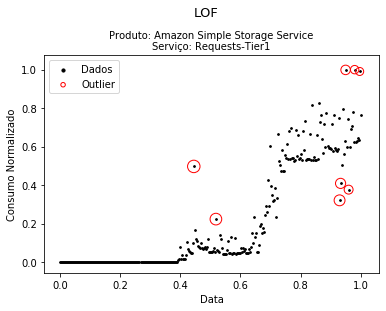

===  Amazon Simple Storage Service  /  Requests-Tier2  ====


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



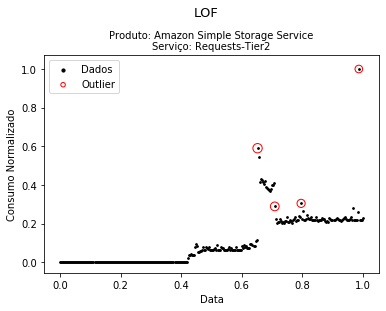

===  Amazon Simple Storage Service  /  SAE1-USE1-AWS-Out-Bytes  ====


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



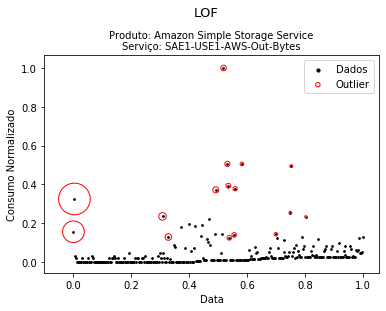

===  EC2 - Other  /  SAE1-DataTransfer-Regional-Bytes  ====


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



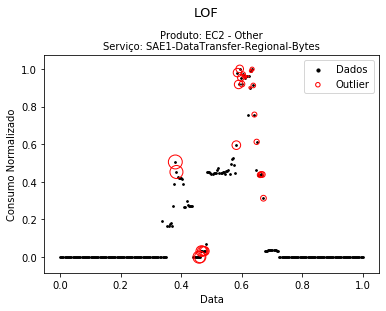

===  EC2 - Other  /  SAE1-EU-AWS-In-Bytes  ====


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



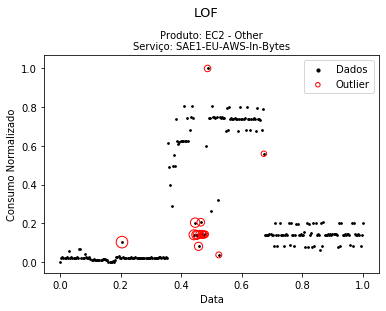

===  EC2 - Other  /  SAE1-NatGateway-Bytes  ====


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



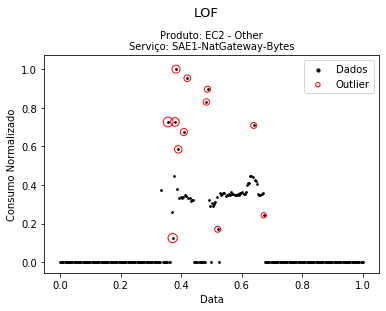

===  Amazon Virtual Private Cloud  /  SAE1-DataTransfer-In-Bytes  ====


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



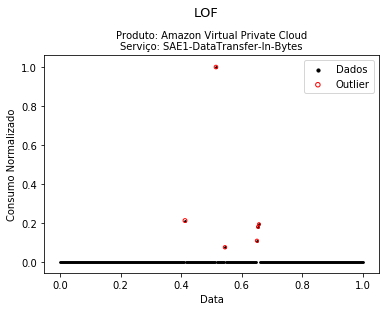

===  Amazon Virtual Private Cloud  /  SAE1-USW2-AWS-In-Bytes  ====


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



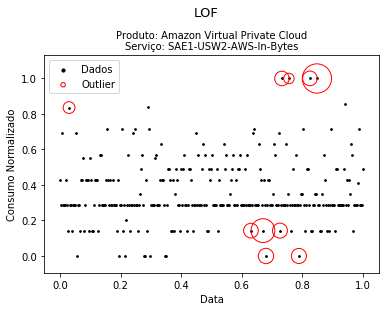

===  Amazon Virtual Private Cloud  /  SAE1-USE1-AWS-In-Bytes  ====


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



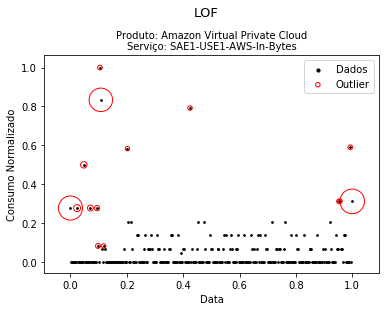

In [43]:
for key in nuvem:
    for value in nuvem[key]:
        produto = key
        servico = value
        print('=== ',produto,' / ', servico,' ====')
        ddo_lof(produto, servico)

## Isolation Forest <a name='iforest' />

In [44]:
def ddo_iforest(produto, servico, max_samples=150, limite=-0.6):
    
    filename = "Series\serie_"+produto+"_"+servico+".csv"
    data = pd.read_csv(filename, index_col=0)
    
    # adaptando o dbscan para séries temporais, transformando as datas em inteiros
    data["inicio"] = pd.to_datetime(data["inicio"]).astype(np.int64)
    
    #normalizando os dados
    scaler_qnt = MinMaxScaler()    
    scaler_qnt.fit(np.array(data['qnt']).reshape(-1,1))
    data['qnt'] = scaler_qnt.transform(np.array(data['qnt']).reshape(-1,1))
    
    scaler_inicio = MinMaxScaler()
    scaler_inicio.fit(np.array(data['inicio']).reshape(-1,1))
    data['inicio'] = scaler_inicio.transform(np.array(data['inicio']).reshape(-1,1))
    
    #criando o modelo
    X = data.values

    clf = IsolationForest(max_samples=max_samples, ) #Manter em 100 ou os 10
    clf.fit(X)
    y_pred = clf.predict(X)

    # plot the line, the samples, and the nearest vectors to the plane
    xx, yy = np.meshgrid(np.linspace(0, 1, 50), np.linspace(0, 1, 50))
    Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    data['pred'] = y_pred
    data['forest_score'] = clf.score_samples(X)
    
    outliers_graph = data[(data['pred']== -1) & (data['forest_score']<limite)]
        
    #voltando o valor da data de inteiro para date
    data['qnt'] = scaler_qnt.inverse_transform(np.array(data['qnt']).reshape(-1,1))
    data['inicio'] = scaler_inicio.inverse_transform(np.array(data['inicio']).reshape(-1,1))
    data["inicio"] = pd.to_datetime(data["inicio"])
    data['inicio'] = data['inicio'].dt.date
    
    #classificando os dados de acordo com a coluna de datas "inicio"
    data =  data.sort_values(by="inicio")
    
    outliers_iforest= data[(data['pred']== -1) & (data['forest_score']<limite)]   

    plt.title("IsolationForest")
    plt.contourf(xx, yy, Z, cmap=plt.cm.Blues_r)
    b1 = plt.scatter(X[:, 0], X[:, 1], c='black', edgecolor='k', s=8)
    # marcando as anomalias em vermelho
    plt.scatter(outliers_graph['inicio'], outliers_graph['qnt'],c='red',edgecolor='k') 
    plt.axis('tight')
    
    plt.suptitle('Isolation Forest',y=1.05,fontsize=13)
    plt.title('Produto: '+produto+'\nServiço: '+servico,fontsize=10, loc='center')
        
    # Nomes dos eixos
    plt.xlabel('Data')
    plt.ylabel('Consumo Normalizado')
    
    
    #Salvando a figura
    filename = "Figuras\\"+produto+"_"+servico+"_iforest.png"
    plt.savefig(filename)    
    
    plt.show()
    
  
    
    outliers_iforest = outliers_iforest.rename(columns={"inicio": "data", "pred": "Forest"})
    outliers_iforest['Forest']=1
    outliers_iforest = outliers_iforest.drop(columns=['qnt', 'forest_score'])
    outliers_iforest = outliers_iforest.set_index('data')
    
       
    #gravando arquivo csv
    filename = "DdO\DdO_Forest_"+produto+"_"+servico+".csv"
    outliers_iforest.to_csv(filename,index = True, header=True)
            
    return outliers_iforest

In [45]:
# ddo_iforest('Amazon Simple Storage Service','SAE1-USE1-AWS-Out-Bytes')

===  Amazon Simple Storage Service  /  Requests-Tier1  ====


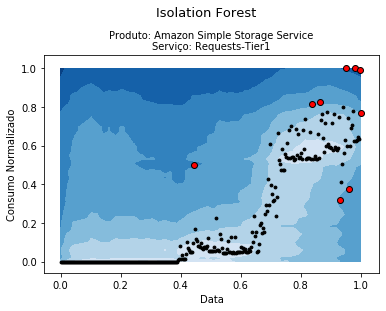

===  Amazon Simple Storage Service  /  Requests-Tier2  ====


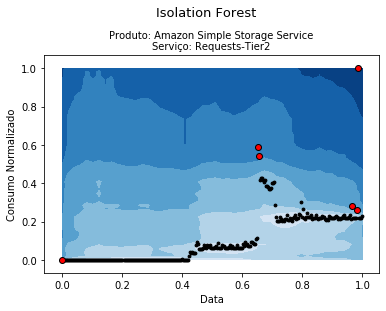

===  Amazon Simple Storage Service  /  SAE1-USE1-AWS-Out-Bytes  ====


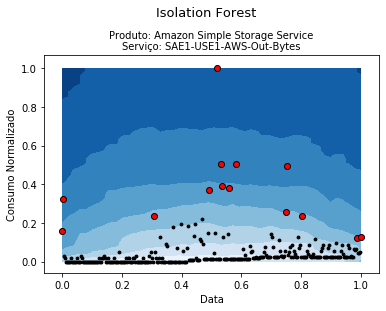

===  EC2 - Other  /  SAE1-DataTransfer-Regional-Bytes  ====


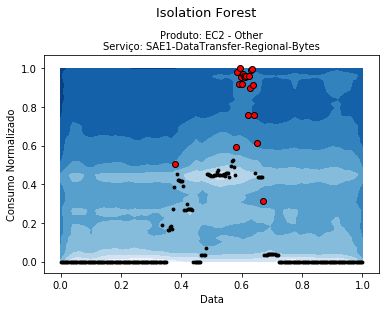

===  EC2 - Other  /  SAE1-EU-AWS-In-Bytes  ====


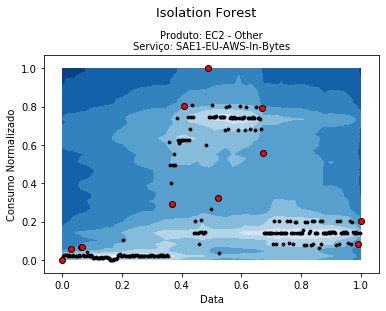

===  EC2 - Other  /  SAE1-NatGateway-Bytes  ====


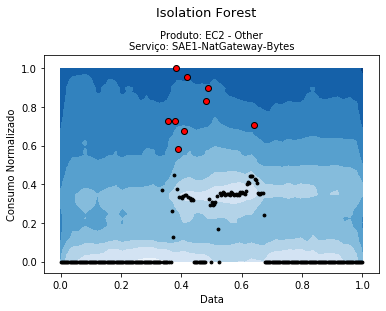

===  Amazon Virtual Private Cloud  /  SAE1-DataTransfer-In-Bytes  ====


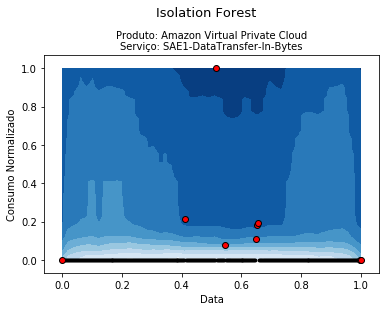

===  Amazon Virtual Private Cloud  /  SAE1-USW2-AWS-In-Bytes  ====


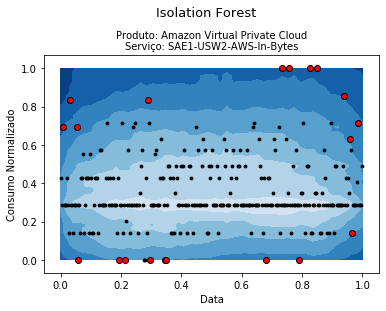

===  Amazon Virtual Private Cloud  /  SAE1-USE1-AWS-In-Bytes  ====


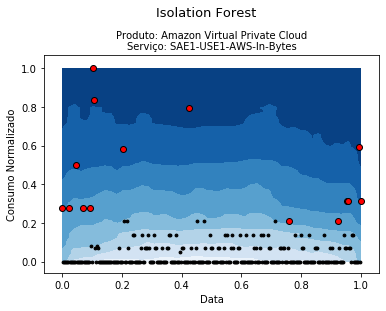

In [46]:
for key in nuvem:
    for value in nuvem[key]:
        produto = key
        servico = value
        print('=== ',produto,' / ', servico,' ====')
        ddo_iforest(produto, servico)

## AVALIAÇÃO DOS MODELOS <a name='avaliacao' />

In [47]:
def evaluate(modelo, produto, servico, outliers_espec):
    
    filename = "DdO\DdO_"+modelo+"_"+produto+"_"+servico+".csv"
    tabela_avaliacao = pd.read_csv(filename)
    tabela_avaliacao['data'] = pd.to_datetime(tabela_avaliacao['data'])
    
    filename = "Series\serie_"+produto+"_"+servico+".csv"
    serie = pd.read_csv(filename, index_col=0).drop(columns=['qnt']).rename(columns={"inicio": "data"})
    
#     print(serie.shape)
    
    serie['data'] = pd.to_datetime(serie['data'])
    serie['aux'] = 0
    serie = pd.merge(serie,tabela_avaliacao,on='data',how='outer')
    serie.fillna(0,inplace=True)
    serie = serie.drop(columns=['aux'])
    serie[modelo] = serie[modelo].astype('int64')
    
    tabela_avaliacao = pd.merge(serie,outliers_espec,on='data',how='outer')    
    tabela_avaliacao.fillna(0,inplace=True)
    tabela_avaliacao = tabela_avaliacao.sort_values(by="data")
    tabela_avaliacao= tabela_avaliacao.set_index('data')
    tabela_avaliacao = tabela_avaliacao.astype('int64')

    
    #gravando arquivo csv da tabela de outliers
    filename = "Tabela Outliers\\"+produto+"_"+servico+"_"+modelo+".csv"
    tabela_avaliacao.to_csv(filename,index = True, header=True)
    
   
    f1 = metrics.f1_score(tabela_avaliacao['especialista'], tabela_avaliacao[modelo])
    auc = metrics.roc_auc_score(tabela_avaliacao['especialista'], tabela_avaliacao[modelo])
    
    fpr, tpr, threshold = metrics.roc_curve(tabela_avaliacao['especialista'], tabela_avaliacao[modelo])
    roc_auc = metrics.auc(fpr, tpr)
    
    #Plotando a curva ROC
#     plt.title('Receiver Operating Characteristic')
#     plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
#     plt.legend(loc = 'lower right')
#     plt.plot([0, 1], [0, 1],'r--')
#     plt.xlim([0, 1])
#     plt.ylim([0, 1])
#     plt.ylabel('True Positive Rate')
#     plt.xlabel('False Positive Rate')
#     plt.show()    
           
    return f1, auc

In [48]:
# evaluate('prophet','Amazon Virtual Private Cloud','SAE1-DataTransfer-In-Bytes', array_to_time_serie(['2020-06-05','2020-07-06','2020-08-17','2020-08-18']))


In [49]:
modelos = ['extremos','prophet', 'holt-winters','sarima','DBSCAN', 'LOF', 'Forest','MLP','LSTM']

In [50]:
#Criando os dataframes para inserção dos resultados de avaliação dos modelos para cada produto/serviço

prod_serv = []

for key in nuvem:
    for value in nuvem[key]:
        produto = key
        servico = value
        prod_serv.append(produto+' // '+servico) 
#         print('=== ',produto,' / ', servico,' ====')
#         ddo_iforest(produto, servico)

# print(prod_serv)

tabela_auc = pd.DataFrame(index=prod_serv, columns=modelos)
tabela_f1 = pd.DataFrame(index=prod_serv, columns=modelos)


## Tabelas F1 e ROC

In [51]:
i = 0

for key in nuvem:
    for value in nuvem[key]:
        
        print(key,value)
                
        for modelo in modelos:
            produto = key
            servico = value    
            
            
            outliers = array_to_time_serie(outliers_espec[i])    
#             print(outliers)
            
            
            f1, auc = evaluate(modelo, produto, servico, outliers)
            tabela_auc[modelo].loc[produto+' // '+servico] = auc
            tabela_f1[modelo].loc[produto+' // '+servico] = f1
        
             
        i=i+1

#gravando arquivo csv
filename = "Tabela Final\Tabela AUC.csv"
tabela_auc.to_csv(filename,index = True, header=True)

#gravando arquivo csv
filename = "Tabela Final\Tabela F1.csv"
tabela_f1.to_csv(filename,index = True, header=True)

print()
print("============ TABELA AUC ===========")
print()

tabela_auc

Amazon Simple Storage Service Requests-Tier1
Amazon Simple Storage Service Requests-Tier2
Amazon Simple Storage Service SAE1-USE1-AWS-Out-Bytes
EC2 - Other SAE1-DataTransfer-Regional-Bytes
EC2 - Other SAE1-EU-AWS-In-Bytes
EC2 - Other SAE1-NatGateway-Bytes
Amazon Virtual Private Cloud SAE1-DataTransfer-In-Bytes
Amazon Virtual Private Cloud SAE1-USW2-AWS-In-Bytes
Amazon Virtual Private Cloud SAE1-USE1-AWS-In-Bytes

============ TABELA AUC ===========



extremos   prophet  \
Amazon Simple Storage Service // Requests-Tier1          0.5  0.835088   
Amazon Simple Storage Service // Requests-Tier2     0.714286  0.761824   
Amazon Simple Storage Service // SAE1-USE1-AWS-...  0.925347  0.956597   
EC2 - Other // SAE1-DataTransfer-Regional-Bytes      0.61117  0.654686   
EC2 - Other // SAE1-EU-AWS-In-Bytes                      0.5  0.676587   
EC2 - Other // SAE1-NatGateway-Bytes                0.636364  0.721224   
Amazon Virtual Private Cloud // SAE1-DataTransf...  0.994983  0.898328   
Amazon Virtual Private Cloud // SAE1-USW2-AWS-I...   0.97561  0.934003   
Amazon Virtual Private Cloud // SAE1-USE1-AWS-I...  0.980969         1   

                                                   holt-winters    sarima  \
Amazon Simple Storage Service // Requests-Tier1        0.764912  0.764912   
Amazon Simple Storage Service // Requests-Tier2        0.714286  0.785714   
Amazon Simple Storage Service // SAE1-USE1-AWS-...     0.663194  0.873264   
EC2 - Other // SAE1-DataTransfer-Regional-Bytes        0.727273  0.818182   
EC2 - Other // SAE1-EU-AWS-In-Bytes                    0.777778  0.775794   
EC2 - Other // SAE1-NatGateway-Bytes                   0.838893  0.859604   
Amazon Virtual Private Cloud // SAE1-DataTransf...          0.6       0.7   
Amazon Virtual Private Cloud // SAE1-USW2-AWS-I...     0.821582  0.900902   
Amazon Virtual Private Cloud // SAE1-USE1-AWS-I...     0.881968   0.99481   

                                                      DBSCAN       LOF  \
Amazon Simple Storage Service // Requests-Tier1     0.694737  0.731579   
Amazon Simple Storage Service // Requests-Tier2     0.785714  0.785714   
Amazon Simple Storage Service // SAE1-USE1-AWS-...  0.831597  0.949653   
EC2 - Other // SAE1-DataTransfer-Regional-Bytes     0.583157   0.63201   
EC2 - Other // SAE1-EU-AWS-In-Bytes                 0.751253  0.619126   
EC2 - Other // SAE1-NatGateway-Bytes                0.754821  0.689604   
Amazon Virtual Private Cloud // SAE1-DataTransf...  0.998328  0.998328   
Amazon Virtual Private Cloud // SAE1-USW2-AWS-I...  0.804161  0.700656   
Amazon Virtual Private Cloud // SAE1-USE1-AWS-I...  0.819493  0.989619   

                                                      Forest       MLP  \
Amazon Simple Storage Service // Requests-Tier1     0.764912  0.864912   
Amazon Simple Storage Service // Requests-Tier2     0.709166  0.642857   
Amazon Simple Storage Service // SAE1-USE1-AWS-...  0.953125  0.916667   
EC2 - Other // SAE1-DataTransfer-Regional-Bytes     0.651049  0.818182   
EC2 - Other // SAE1-EU-AWS-In-Bytes                    0.625  0.861111   
EC2 - Other // SAE1-NatGateway-Bytes                0.695652  0.931818   
Amazon Virtual Private Cloud // SAE1-DataTransf...  0.993311       0.7   
Amazon Virtual Private Cloud // SAE1-USW2-AWS-I...  0.932466  0.883275   
Amazon Virtual Private Cloud // SAE1-USE1-AWS-I...  0.989619   0.99308   

                                                        LSTM  
Amazon Simple Storage Service // Requests-Tier1     0.766667  
Amazon Simple Storage Service // Requests-Tier2     0.642857  
Amazon Simple Storage Service // SAE1-USE1-AWS-...  0.791667  
EC2 - Other // SAE1-DataTransfer-Regional-Bytes     0.772727  
EC2 - Other // SAE1-EU-AWS-In-Bytes                 0.775794  
EC2 - Other // SAE1-NatGateway-Bytes                0.818182  
Amazon Virtual Private Cloud // SAE1-DataTransf...       0.7  
Amazon Virtual Private Cloud // SAE1-USW2-AWS-I...  0.920066  
Amazon Virtual Private Cloud // SAE1-USE1-AWS-I...  0.887159

In [52]:
print()
print("============ TABELA F1 ===========")
print()

tabela_f1


============ TABELA F1 ===========



extremos   prophet  \
Amazon Simple Storage Service // Requests-Tier1            0       0.5   
Amazon Simple Storage Service // Requests-Tier2          0.6      0.32   
Amazon Simple Storage Service // SAE1-USE1-AWS-...   0.52381  0.916667   
EC2 - Other // SAE1-DataTransfer-Regional-Bytes     0.222222  0.275862   
EC2 - Other // SAE1-EU-AWS-In-Bytes                        0  0.411765   
EC2 - Other // SAE1-NatGateway-Bytes                0.428571  0.571429   
Amazon Virtual Private Cloud // SAE1-DataTransf...  0.769231       0.8   
Amazon Virtual Private Cloud // SAE1-USW2-AWS-I...  0.708333  0.592593   
Amazon Virtual Private Cloud // SAE1-USE1-AWS-I...   0.62069         1   

                                                   holt-winters    sarima  \
Amazon Simple Storage Service // Requests-Tier1        0.666667  0.666667   
Amazon Simple Storage Service // Requests-Tier2             0.6  0.727273   
Amazon Simple Storage Service // SAE1-USE1-AWS-...     0.444444  0.818182   
EC2 - Other // SAE1-DataTransfer-Regional-Bytes           0.625  0.777778   
EC2 - Other // SAE1-EU-AWS-In-Bytes                    0.714286  0.689655   
EC2 - Other // SAE1-NatGateway-Bytes                   0.789474       0.8   
Amazon Virtual Private Cloud // SAE1-DataTransf...     0.333333  0.571429   
Amazon Virtual Private Cloud // SAE1-USW2-AWS-I...     0.510638  0.438356   
Amazon Virtual Private Cloud // SAE1-USE1-AWS-I...          0.7  0.857143   

                                                      DBSCAN       LOF  \
Amazon Simple Storage Service // Requests-Tier1          0.5  0.608696   
Amazon Simple Storage Service // Requests-Tier2     0.727273  0.727273   
Amazon Simple Storage Service // SAE1-USE1-AWS-...  0.761905  0.785714   
EC2 - Other // SAE1-DataTransfer-Regional-Bytes     0.235294  0.195122   
EC2 - Other // SAE1-EU-AWS-In-Bytes                 0.571429   0.30303   
EC2 - Other // SAE1-NatGateway-Bytes                0.631579  0.514286   
Amazon Virtual Private Cloud // SAE1-DataTransf...  0.909091  0.909091   
Amazon Virtual Private Cloud // SAE1-USW2-AWS-I...  0.421053  0.518519   
Amazon Virtual Private Cloud // SAE1-USE1-AWS-I...  0.521739      0.75   

                                                      Forest       MLP  \
Amazon Simple Storage Service // Requests-Tier1     0.666667  0.814815   
Amazon Simple Storage Service // Requests-Tier2     0.461538  0.444444   
Amazon Simple Storage Service // SAE1-USE1-AWS-...  0.846154  0.909091   
EC2 - Other // SAE1-DataTransfer-Regional-Bytes     0.258065  0.777778   
EC2 - Other // SAE1-EU-AWS-In-Bytes                 0.333333   0.83871   
EC2 - Other // SAE1-NatGateway-Bytes                  0.5625  0.926829   
Amazon Virtual Private Cloud // SAE1-DataTransf...  0.714286  0.571429   
Amazon Virtual Private Cloud // SAE1-USW2-AWS-I...  0.810811  0.336634   
Amazon Virtual Private Cloud // SAE1-USE1-AWS-I...      0.75  0.818182   

                                                        LSTM  
Amazon Simple Storage Service // Requests-Tier1     0.695652  
Amazon Simple Storage Service // Requests-Tier2     0.444444  
Amazon Simple Storage Service // SAE1-USE1-AWS-...  0.736842  
EC2 - Other // SAE1-DataTransfer-Regional-Bytes     0.705882  
EC2 - Other // SAE1-EU-AWS-In-Bytes                 0.689655  
EC2 - Other // SAE1-NatGateway-Bytes                0.777778  
Amazon Virtual Private Cloud // SAE1-DataTransf...  0.571429  
Amazon Virtual Private Cloud // SAE1-USW2-AWS-I...  0.516129  
Amazon Virtual Private Cloud // SAE1-USE1-AWS-I...  0.823529

In [53]:
classificacao_auc = pd.DataFrame()
classificacao_auc['Modelo'] = modelos
media_auc = []

for modelo in modelos: 
#     print(modelo)
#     print(round(np.mean(tabela_auc[modelo]),3))
    media_auc.append(round(np.mean(tabela_auc[modelo]),3))
    

classificacao_auc['Media AUC'] = media_auc
classificacao_auc = classificacao_auc.set_index('Modelo')
classificacao_auc = classificacao_auc.sort_values(by='Media AUC', ascending=False)

#gravando arquivo csv
filename = "Tabela Final\Classificacao AUC.csv"
classificacao_auc.to_csv(filename,index = True, header=True)
    
classificacao_auc

Media AUC
Modelo                 
MLP               0.846
sarima            0.830
prophet           0.826
Forest            0.813
LOF               0.788
LSTM              0.786
DBSCAN            0.780
extremos          0.760
holt-winters      0.754

#### Plotar o gráfico AUC

https://www.analyticsvidhya.com/blog/2020/06/auc-roc-curve-machine-learning/

![image.png](attachment:image.png)

Plotar matriz de confusão pro melhor modelo

![image.png](attachment:image.png)

Sliding window: https://medium.com/@krzysztofdrelczuk/time-series-anomaly-detection-with-python-example-a92ef262f09a

https://github.com/kdrelczuk/medium/blob/master/anomalies_local.py


http://ethen8181.github.io/machine-learning/time_series/3_supervised_time_series.html

In [54]:
# tabela_f1

In [55]:
classificacao_f1 = pd.DataFrame()
classificacao_f1['Modelo'] = modelos
media_auc = []

for modelo in modelos:
#     print(modelo)
#     print(round(np.mean(tabela_f1[modelo]),3))
    media_auc.append(round(np.mean(tabela_f1[modelo]),3))
    

classificacao_f1['Media F1'] = media_auc
classificacao_f1 = classificacao_f1.set_index('Modelo')
classificacao_f1 = classificacao_f1.sort_values(by='Media F1', ascending=False)

#gravando arquivo csv
filename = "Tabela Final\Classificacao F1.csv"
classificacao_f1.to_csv(filename,index = True, header=True)

classificacao_f1

Media F1
Modelo                
MLP              0.715
sarima           0.705
LSTM             0.662
Forest           0.600
prophet          0.599
holt-winters     0.598
LOF              0.590
DBSCAN           0.587
extremos         0.430

In [56]:
classificacao_geral = classificacao_f1.sort_values(by="Modelo")
classificacao_auc = classificacao_auc.sort_values(by="Modelo")
classificacao_geral['Media AUC'] = classificacao_auc['Media AUC']
classificacao_geral = classificacao_geral.sort_values(by="Media F1",ascending=False )
classificacao_geral

Media F1  Media AUC
Modelo                           
MLP              0.715      0.846
sarima           0.705      0.830
LSTM             0.662      0.786
Forest           0.600      0.813
prophet          0.599      0.826
holt-winters     0.598      0.754
LOF              0.590      0.788
DBSCAN           0.587      0.780
extremos         0.430      0.760

In [57]:
classificacao_geral.index

Index(['MLP', 'sarima', 'LSTM', 'Forest', 'prophet', 'holt-winters', 'LOF',
       'DBSCAN', 'extremos'],
      dtype='object', name='Modelo')

In [58]:
# # plt.figure(figsize=(15,10))

# graph = sns.barplot(x=classificacao_geral['Media AUC'], y=classificacao_geral.index,orient='h',
#                  order=['MLP', 'sarima','prophet', 'Forest','LOF','DBSCAN', 'LSTM','extremos','holt-winters'],
                 
         
#                 )
# plt.xlabel("Média AUC-ROC")


# # for p in graph.patches:
# #     print(p.get_width())
# #     print(p.get_x())
# #     print(p.get_y())
    

# sns.set(rc={'figure.figsize':(8,5)})
# for p in graph.patches:
#     graph.annotate(format(p.get_width(), '.3f'), 
#                    (
#                     p.get_width()+0.015, 
#                     p.get_y()-0.1),
# #                    ha = 'center',
# #                    va = 'center', 
# #                    xytext = (0, 9), 
# #                    textcoords = 'offset points',
#                    color='black'
#                   )


In [59]:
# # plt.figure(figsize=(15,10))

# graph = sns.barplot(x=classificacao_geral['Media F1'], y=classificacao_geral.index,orient='h',
#                  order=['MLP', 'sarima','LSTM','Forest','holt-winters','LOF','DBSCAN', 'prophet','extremos'],
                          
#                 )
# plt.xlabel("Média F1")


# # for p in graph.patches:
# #     print(p.get_width())
# #     print(p.get_x())
# #     print(p.get_y())
    

# sns.set(rc={'figure.figsize':(8,5)})
# for p in graph.patches:
#     graph.annotate(format(p.get_width(), '.3f'), 
#                    (
#                     p.get_width(), 
#                     p.get_y()),
# #                    ha = 'center',
# #                    va = 'center', 
# #                    xytext = (0, 9), 
# #                    textcoords = 'offset points',
#                    color='black'
#                   )

## Sumário

<a href=#fig>Figura</a>

<a href=#leitura>Leitura e Pré-processamento da base de dados</a>
<br><a href=#filtragem>Filtragem dos Dados</a>
<br><a href=#produtos>Seleção dos Produtos e Serviços</a>
<br><a href=#out_esp>Outliers</a>
<br><a href=#extreme>Extremos</a>
<br><a href=#prophet>Prophet</a>
<br><a href=#hw>Holt-Winters</a>
<br><a href=#sarima>SARIMA</a>
<br><a href=#dbscan>DBSCAN</a>
<br><a href=#lof>LOF</a>
<br><a href=#iforest>Isolation Forest</a>
<br><a href=#avaliacao>Avaliacao</a>

In [60]:
import winsound
duration = 1*600  # milliseconds
freq = 1040  # Hz
winsound.Beep(freq, duration)
winsound.Beep(freq, duration)
winsound.Beep(freq, duration)

In [61]:
# import winsound
# duration = 1*700  # milliseconds
# freq = 440  # Hz
# winsound.Beep(freq, duration)
# winsound.Beep(freq, duration)
# winsound.Beep(freq, duration)